## Import Packages & Data

In [ ]:
#%pip install numpy pandas matplotlib seaborn scorecardpy

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scorecardpy as sc

In [2]:
application = pd.read_csv('data/IS453 Group Assignment - Application Data.csv')
bureau = pd.read_csv('data/IS453 Group Assignment - Bureau Data.csv')

In [3]:
print(application.shape)
print(application.columns)
print(bureau.shape)
print(bureau.columns)

(307511, 120)
Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=120)
(1716428, 17)
Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY'],
      dtype='object')


## Prepare Data

### Filter dataset

In [4]:
# filter for applicants that do not own a car
application = application[application['FLAG_OWN_CAR'] == 'N']

# filter bureau dataset for CREDIT_CURRENCY = currency 1
bureau = bureau[bureau['CREDIT_CURRENCY'] == 'currency 1']

bureau = bureau.drop(columns=['CREDIT_CURRENCY'])

print(application.shape)
print(bureau.shape)

(202924, 120)
(1715020, 16)


In [5]:
print(application.columns)

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=120)


In [6]:
bureau['CREDIT_TYPE'].value_counts()

CREDIT_TYPE
Consumer credit                                 1250869
Credit card                                      402071
Car loan                                          27274
Mortgage                                          18295
Microloan                                         12413
Loan for business development                      1954
Another type of loan                               1014
Unknown type of loan                                554
Loan for working capital replenishment              469
Cash loan (non-earmarked)                            56
Real estate loan                                     26
Loan for the purchase of equipment                   19
Loan for purchase of shares (margin lending)          4
Mobile operator loan                                  1
Interbank credit                                      1
Name: count, dtype: int64

In [7]:
agg_bureau = bureau.copy()

# precompute credit status counts
agg_bureau['NUM_ACTIVE_CREDITS'] = (agg_bureau['CREDIT_ACTIVE'] == 'Active').astype(int)
agg_bureau['NUM_CLOSED_CREDITS'] = (agg_bureau['CREDIT_ACTIVE'] == 'Closed').astype(int)
agg_bureau['NUM_BADDEBT_CREDITS'] = (agg_bureau['CREDIT_ACTIVE'] == 'Bad debt').astype(int)

# precompute top 5 most common credit type counts
agg_bureau['NUM_CONSUMER_CREDIT_LOANS'] = (agg_bureau['CREDIT_TYPE'] == 'Consumer credit').astype(int)
agg_bureau['NUM_CREDIT_CARD_LOANS'] = (agg_bureau['CREDIT_TYPE'] == 'Credit card').astype(int)
agg_bureau['NUM_CAR_LOANS'] = (agg_bureau['CREDIT_TYPE'] == 'Car loan').astype(int)
agg_bureau['NUM_MORTGAGE_LOANS'] = (agg_bureau['CREDIT_TYPE'] == 'Mortgage').astype(int)
agg_bureau['NUM_MICRO_LOANS'] = (agg_bureau['CREDIT_TYPE'] == 'Microloan').astype(int)

# DEBT_CREDIT_RATIO = AMT_CREDIT_SUM_DEBT / AMT_CREDIT_SUM
agg_bureau['DEBT_CREDIT_RATIO'] = agg_bureau['AMT_CREDIT_SUM_DEBT'] / agg_bureau['AMT_CREDIT_SUM']

### Flatten bureau data

In [8]:
# flatten bureau data
agg_bureau = agg_bureau.groupby('SK_ID_CURR').agg(
    NUM_PREV_LOANS = ('SK_ID_BUREAU', 'count'),
    NUM_ACTIVE_CREDITS = ('NUM_ACTIVE_CREDITS', 'sum'),
    NUM_CLOSED_CREDITS = ('NUM_CLOSED_CREDITS', 'sum'),
    NUM_CONSUMER_CREDIT_LOANS = ('NUM_CONSUMER_CREDIT_LOANS', 'sum'),
    NUM_CREDIT_CARD_LOANS = ('NUM_CREDIT_CARD_LOANS', 'sum'),
    NUM_CAR_LOANS = ('NUM_CAR_LOANS', 'sum'),
    NUM_MORTGAGE_LOANS = ('NUM_MORTGAGE_LOANS', 'sum'),
    NUM_MICRO_LOANS = ('NUM_MICRO_LOANS', 'sum'),
    DAYS_CREDIT_MIN = ('DAYS_CREDIT', 'min'), # capture the oldest credit application
    DAYS_CREDIT_MAX = ('DAYS_CREDIT', 'max'), # find most recent credit application
    DAYS_CREDIT_MEAN = ('DAYS_CREDIT', 'mean'), # avg days before current application, for prev credit lines
    DAYS_CREDIT_OVERDUE_MAX = ('CREDIT_DAY_OVERDUE', 'max'),
    DAYS_CREDIT_OVERDUE_MEAN = ('CREDIT_DAY_OVERDUE', 'mean'),
    DAYS_CREDIT_ENDDATE_MEAN = ('DAYS_CREDIT_ENDDATE', 'mean'),
    CNT_CREDIT_PROLONG_MAX = ('CNT_CREDIT_PROLONG', 'max'),
    CNT_CREDIT_PROLONG_MEAN = ('CNT_CREDIT_PROLONG', 'mean'),
    AMT_CREDIT_SUM_LIMIT_MEAN = ('AMT_CREDIT_SUM_LIMIT', 'mean'),
    AMT_CREDIT_SUM_OVERDUE_SUM = ('AMT_CREDIT_SUM_OVERDUE', 'sum'),
    AMT_CREDIT_SUM_OVERDUE_MAX = ('AMT_CREDIT_SUM_OVERDUE', 'max'),
    DAYS_CREDIT_UPDATE_MEAN = ('DAYS_CREDIT_UPDATE', 'mean'),
    DEBT_CREDIT_RATIO_MEAN = ('DEBT_CREDIT_RATIO', 'mean'),
    AMT_ANNUITY_MEAN = ('AMT_ANNUITY', 'mean'),
).reset_index()

## Merge Datasets

In [9]:
print(application.shape)
print(bureau.shape)
print(agg_bureau.shape)

(202924, 120)
(1715020, 16)
(305773, 23)


In [10]:
merged = pd.merge(left=application, right=agg_bureau, on='SK_ID_CURR', how='left')
print(merged.shape)

(202924, 142)


## Calculate IVs for each x variable

In [11]:
# get target & independent variables
cols = merged.columns.to_list()[1:]
print(cols)

merged_working = merged.copy()

['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG',

In [12]:
# Creates a copy of the dataframe into a csv file
merged_working.to_csv('merged.csv', index=False)

In [13]:
# unable to calculate WOE & IV for ORGANIZATION_TYPE as it is because it has too many possible categories
    # group some values together

mapping = {
    'Business Entity Type 1': 'Business Entity',
    'Business Entity Type 2': 'Business Entity',
    'Business Entity Type 3': 'Business Entity',
    'Trade: type 7': 'Trade',
    'Trade: type 3': 'Trade',
    'Trade: type 2': 'Trade',
    'Trade: type 6': 'Trade',
    'Trade: type 1': 'Trade',
    'Trade: type 4': 'Trade',
    'Trade: type 5': 'Trade',
    'Transport: type 1': 'Transport',
    'Transport: type 2': 'Transport',
    'Transport: type 3': 'Transport',
    'Transport: type 4': 'Transport',
    'Industry: type 3': 'Industry',
    'Industry: type 11': 'Industry',
    'Industry: type 9': 'Industry',
    'Industry: type 7': 'Industry',
    'Industry: type 1': 'Industry',
    'Industry: type 4': 'Industry',
    'Industry: type 5': 'Industry',
    'Industry: type 6': 'Industry',
    'Industry: type 2': 'Industry',
    'Industry: type 10': 'Industry',
    'Industry: type 12': 'Industry',
    'Industry: type 13': 'Industry',
    'Industry: type 8': 'Industry',
    'Government': 'Public Sector',
    'Transport': 'Public Sector',
    'Military': 'Public Sector',
    'Police': 'Public Sector',
    'Hotel': 'Hospitality',
    'Restaurant': 'Hospitality',
    'Bank': 'Financial Services',
    'Insurance': 'Financial Services',
}

merged_working['ORGANIZATION_TYPE'] = merged_working['ORGANIZATION_TYPE'].replace(mapping)
print(merged_working['ORGANIZATION_TYPE'].value_counts())

ORGANIZATION_TYPE
Business Entity        50934
XNA                    45205
Self-employed          23916
Other                  10739
Trade                   9680
Public Sector           9382
Industry                8752
Medicine                8270
School                  6471
Kindergarten            5404
Transport               4300
Construction            3445
Hospitality             2052
Financial Services      1985
Security                1829
Housing                 1817
Postal                  1684
Agriculture             1450
Services                1122
Security Ministries     1109
University               901
Electricity              568
Telecom                  340
Culture                  271
Advertising              269
Emergency                242
Realtor                  211
Cleaning                 195
Mobile                   185
Legal Services           145
Religion                  51
Name: count, dtype: int64


In [14]:
merged_working.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202924 entries, 0 to 202923
Columns: 142 entries, SK_ID_CURR to AMT_ANNUITY_MEAN
dtypes: float64(85), int64(41), object(16)
memory usage: 219.8+ MB


In [15]:
merged_working = merged_working.loc[:, cols]

# automatically calculate bin ranges, WOE, and IV for the independent variables
bins = sc.woebin(merged_working, y='TARGET')

# scorecardpy calcualtes WoE as the opposite of the normal formula
for variable, bindetails in bins.items():
    bins[variable]['woe'] = bins[variable]['woe'] * -1

# print bin details and IV
for variable, bindetails in bins.items():
    print(variable , ": ")
    print('IV: ' + str(round(bindetails['total_iv'][0],4)))
    display(bindetails)
    print("--"*50)

[INFO] creating woe binning ...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scorecardpy/woebin.py:361: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  init_bin = init_bin.groupby('brkp', group_keys=False).agg({
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scorecardpy/woebin.py:361: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  init_bin = init_bin.groupby('brkp', group_keys=False).agg({
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scorecardpy/woebin.py:414: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy

Binning on 202924 rows and 137 columns in 00:00:46
NAME_INCOME_TYPE : 
IV: 0.0726


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_INCOME_TYPE,"Businessman%,%Student%,%Pensioner",45214,0.222812,42724,2490,0.055071,0.466234,0.039977,0.072642,"Businessman%,%Student%,%Pensioner",False
1,NAME_INCOME_TYPE,State servant,14243,0.070189,13367,876,0.061504,0.348935,0.007399,0.072642,State servant,False
2,NAME_INCOME_TYPE,Commercial associate,43576,0.214740,40011,3565,0.081811,0.041747,0.000368,0.072642,Commercial associate,False
3,NAME_INCOME_TYPE,"Working%,%Maternity leave%,%Unemployed",99891,0.492258,89573,10318,0.103293,-0.215080,0.024898,0.072642,"Working%,%Maternity leave%,%Unemployed",False


----------------------------------------------------------------------------------------------------
LIVINGAREA_MEDI : 
IV: 0.0359


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,LIVINGAREA_MEDI,missing,99450,0.490085,89808,9642,0.096953,-0.144698,0.010897,0.035864,missing,True
1,LIVINGAREA_MEDI,"[-inf,0.03)",18547,0.091399,16809,1738,0.093708,-0.107064,0.001095,0.035864,0.03,False
2,LIVINGAREA_MEDI,"[0.03,0.08)",38026,0.187390,35125,2901,0.076290,0.117614,0.002469,0.035864,0.08,False
3,LIVINGAREA_MEDI,"[0.08,0.19)",31851,0.156960,29753,2098,0.065869,0.275702,0.010645,0.035864,0.19,False
4,LIVINGAREA_MEDI,"[0.19,inf)",15050,0.074166,14180,870,0.057807,0.414851,0.010758,0.035864,inf,False


----------------------------------------------------------------------------------------------------
OBS_30_CNT_SOCIAL_CIRCLE : 
IV: 0.0028


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,OBS_30_CNT_SOCIAL_CIRCLE,missing,658,0.003243,635,23,0.034954,0.941887,0.001965,0.002797,missing,True
1,OBS_30_CNT_SOCIAL_CIRCLE,"[-inf,2.0)",140591,0.692826,128786,11805,0.083967,0.013385,0.000123,0.002797,2.0,False
2,OBS_30_CNT_SOCIAL_CIRCLE,"[2.0,4.0)",32939,0.162322,30120,2819,0.085582,-0.007436,0.000009,0.002797,4.0,False
3,OBS_30_CNT_SOCIAL_CIRCLE,"[4.0,inf)",28736,0.141610,26134,2602,0.090548,-0.069287,0.000700,0.002797,inf,False


----------------------------------------------------------------------------------------------------
NAME_HOUSING_TYPE : 
IV: 0.0177


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_HOUSING_TYPE,"Co-op apartment%,%Office apartment%,%House / a...",189953,0.93608,174367,15586,0.082052,0.038546,0.001369,0.01768,"Co-op apartment%,%Office apartment%,%House / a...",False
1,NAME_HOUSING_TYPE,"With parents%,%Rented apartment",12971,0.06392,11308,1663,0.128209,-0.459356,0.016311,0.01768,"With parents%,%Rented apartment",False


----------------------------------------------------------------------------------------------------
LANDAREA_AVG : 
IV: 0.0194


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,LANDAREA_AVG,missing,118423,0.583583,107363,11060,0.093394,-0.103363,0.006508,0.019366,missing,True
1,LANDAREA_AVG,"[-inf,0.005)",11320,0.055784,10479,841,0.074293,0.146293,0.001124,0.019366,0.005,False
2,LANDAREA_AVG,"[0.005,0.05)",32267,0.159010,29702,2565,0.079493,0.073012,0.000822,0.019366,0.05,False
3,LANDAREA_AVG,"[0.05,0.075)",15242,0.075112,14155,1087,0.071316,0.190403,0.002517,0.019366,0.075,False
4,LANDAREA_AVG,"[0.075,inf)",25672,0.126510,23976,1696,0.066064,0.272537,0.008395,0.019366,inf,False


----------------------------------------------------------------------------------------------------
FLOORSMAX_AVG : 
IV: 0.039


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLOORSMAX_AVG,missing,98563,0.485714,88960,9603,0.097430,-0.150132,0.011652,0.038997,missing,True
1,FLOORSMAX_AVG,"[-inf,0.16)",22797,0.112343,20704,2093,0.091810,-0.084515,0.000831,0.038997,0.16,False
2,FLOORSMAX_AVG,"[0.16,0.24)",44767,0.220610,41440,3327,0.074318,0.145932,0.004422,0.038997,0.24,False
3,FLOORSMAX_AVG,"[0.24,0.36)",24194,0.119227,22647,1547,0.063941,0.307466,0.009926,0.038997,0.36,False
4,FLOORSMAX_AVG,"[0.36,inf)",12603,0.062107,11924,679,0.053876,0.489444,0.012165,0.038997,inf,False


----------------------------------------------------------------------------------------------------
FLOORSMAX_MEDI : 
IV: 0.039


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLOORSMAX_MEDI,missing,98563,0.485714,88960,9603,0.097430,-0.150132,0.011652,0.038961,missing,True
1,FLOORSMAX_MEDI,"[-inf,0.16)",22619,0.111465,20538,2081,0.092002,-0.086815,0.000871,0.038961,0.16,False
2,FLOORSMAX_MEDI,"[0.16,0.24)",45072,0.222113,41723,3349,0.074303,0.146147,0.004465,0.038961,0.24,False
3,FLOORSMAX_MEDI,"[0.24,0.34)",23972,0.118133,22446,1526,0.063658,0.312219,0.010122,0.038961,0.34,False
4,FLOORSMAX_MEDI,"[0.34,inf)",12698,0.062575,12008,690,0.054339,0.480393,0.011851,0.038961,inf,False


----------------------------------------------------------------------------------------------------
REGION_POPULATION_RELATIVE : 
IV: 0.0333


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REGION_POPULATION_RELATIVE,"[-inf,0.012)",71064,0.350200,64852,6212,0.087414,-0.030619,0.000333,0.033316,0.012,False
1,REGION_POPULATION_RELATIVE,"[0.012,0.02)",45336,0.223414,41053,4283,0.094472,-0.116033,0.003156,0.033316,0.02,False
2,REGION_POPULATION_RELATIVE,"[0.02,0.021)",10304,0.050778,9103,1201,0.116557,-0.350794,0.007227,0.033316,0.021,False
3,REGION_POPULATION_RELATIVE,"[0.021,0.032)",48653,0.239760,44710,3943,0.081043,0.052012,0.000635,0.033316,0.032,False
4,REGION_POPULATION_RELATIVE,"[0.032,0.036000000000000004)",13870,0.068351,12935,935,0.067412,0.250902,0.003879,0.033316,0.036000000000000004,False
5,REGION_POPULATION_RELATIVE,"[0.036000000000000004,inf)",13697,0.067498,13022,675,0.049281,0.583439,0.018087,0.033316,inf,False


----------------------------------------------------------------------------------------------------
NONLIVINGAPARTMENTS_AVG : 
IV: 0.0124


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NONLIVINGAPARTMENTS_AVG,missing,139942,0.689628,127257,12685,0.090645,-0.070455,0.003525,0.012449,missing,True
1,NONLIVINGAPARTMENTS_AVG,"[-inf,0.0035)",38461,0.189534,35670,2791,0.072567,0.171666,0.005202,0.012449,0.0035,False
2,NONLIVINGAPARTMENTS_AVG,"[0.0035,0.01)",14346,0.070696,13270,1076,0.075003,0.136012,0.001236,0.012449,0.01,False
3,NONLIVINGAPARTMENTS_AVG,"[0.01,inf)",10175,0.050142,9478,697,0.068501,0.233700,0.002486,0.012449,inf,False


----------------------------------------------------------------------------------------------------
DAYS_CREDIT_ENDDATE_MEAN : 
IV: 0.0756


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_CREDIT_ENDDATE_MEAN,missing,32760,0.161440,29311,3449,0.105281,-0.236365,0.009949,0.075573,missing,True
1,DAYS_CREDIT_ENDDATE_MEAN,"[-inf,-400.0)",67076,0.330547,63205,3871,0.057711,0.416627,0.048324,0.075573,-400.0,False
2,DAYS_CREDIT_ENDDATE_MEAN,"[-400.0,-200.0)",15502,0.076393,14361,1141,0.073603,0.156367,0.001751,0.075573,-200.0,False
3,DAYS_CREDIT_ENDDATE_MEAN,"[-200.0,inf)",87586,0.431620,78798,8788,0.100336,-0.182743,0.015550,0.075573,inf,False


----------------------------------------------------------------------------------------------------
AMT_CREDIT_SUM_LIMIT_MEAN : 
IV: 0.0175


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_CREDIT_SUM_LIMIT_MEAN,missing,44926,0.221393,40492,4434,0.098696,-0.164441,0.006410,0.017463,missing,True
1,AMT_CREDIT_SUM_LIMIT_MEAN,"[-inf,2000.0)",134251,0.661583,123584,10667,0.079456,0.073523,0.003469,0.017463,2000.0,False
2,AMT_CREDIT_SUM_LIMIT_MEAN,"[2000.0,20000.0)",12393,0.061072,11039,1354,0.109255,-0.277872,0.005292,0.017463,20000.0,False
3,AMT_CREDIT_SUM_LIMIT_MEAN,"[20000.0,inf)",11354,0.055952,10560,794,0.069931,0.211501,0.002293,0.017463,inf,False


----------------------------------------------------------------------------------------------------
DAYS_EMPLOYED : 
IV: 0.1267


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_EMPLOYED,"[-inf,-4000.0)",28347,0.139693,26856,1491,0.052598,0.514799,0.029961,0.126721,-4000.0,False
1,DAYS_EMPLOYED,"[-4000.0,-2000.0)",38617,0.190303,35634,2983,0.077246,0.104127,0.001976,0.126721,-2000.0,False
2,DAYS_EMPLOYED,"[-2000.0,-1000.0)",38474,0.189598,34491,3983,0.103524,-0.217581,0.009824,0.126721,-1000.0,False
3,DAYS_EMPLOYED,"[-1000.0,0.0)",52279,0.257628,45984,6295,0.120412,-0.387706,0.045474,0.126721,0.0,False
4,DAYS_EMPLOYED,"[0.0,inf)",45207,0.222778,42710,2497,0.055235,0.463099,0.039486,0.126721,inf,False


----------------------------------------------------------------------------------------------------
AMT_ANNUITY : 
IV: 0.0227


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_ANNUITY,missing,9,0.000044,9,0,0.000000,-0.073606,2.725220e-07,0.022672,missing,True
1,AMT_ANNUITY,"[-inf,16000.0)",52107,0.256781,48266,3841,0.073714,0.154803,5.771197e-03,0.022672,16000.0,False
2,AMT_ANNUITY,"[16000.0,24000.0)",52549,0.258959,47845,4704,0.089516,-0.056638,8.504661e-04,0.022672,24000.0,False
3,AMT_ANNUITY,"[24000.0,42000.0)",75246,0.370809,68023,7223,0.095992,-0.133616,6.997720e-03,0.022672,42000.0,False
4,AMT_ANNUITY,"[42000.0,inf)",23013,0.113407,21532,1481,0.064355,0.300631,9.052155e-03,0.022672,inf,False


----------------------------------------------------------------------------------------------------
AMT_INCOME_TOTAL : 
IV: 0.0049


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_INCOME_TOTAL,"[-inf,80000.0)",22711,0.111919,20854,1857,0.081767,0.042340,0.000197,0.004895,80000.0,False
1,AMT_INCOME_TOTAL,"[80000.0,190000.0)",132931,0.655078,121211,11720,0.088166,-0.040008,0.001066,0.004895,190000.0,False
2,AMT_INCOME_TOTAL,"[190000.0,220000.0)",12749,0.062826,11675,1074,0.084242,0.009816,0.000006,0.004895,220000.0,False
3,AMT_INCOME_TOTAL,"[220000.0,260000.0)",16257,0.080114,14950,1307,0.080396,0.060733,0.000288,0.004895,260000.0,False
4,AMT_INCOME_TOTAL,"[260000.0,inf)",18276,0.090063,16985,1291,0.070639,0.200670,0.003338,0.004895,inf,False


----------------------------------------------------------------------------------------------------
DAYS_CREDIT_MEAN : 
IV: 0.1201


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_CREDIT_MEAN,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.120132,missing,True
1,DAYS_CREDIT_MEAN,"[-inf,-1200.0)",66845,0.329409,63117,3728,0.055771,0.452875,0.056068,0.120132,-1200.0,False
2,DAYS_CREDIT_MEAN,"[-1200.0,-850.0)",40261,0.198404,37323,2938,0.072974,0.165637,0.005082,0.120132,-850.0,False
3,DAYS_CREDIT_MEAN,"[-850.0,-500.0)",35046,0.172705,31700,3346,0.095475,-0.127693,0.002969,0.120132,-500.0,False
4,DAYS_CREDIT_MEAN,"[-500.0,inf)",29543,0.145587,25584,3959,0.134008,-0.510268,0.046808,0.120132,inf,False


----------------------------------------------------------------------------------------------------
NONLIVINGAREA_MODE : 
IV: 0.0236


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NONLIVINGAREA_MODE,missing,110140,0.542765,99607,10533,0.095633,-0.129524,0.009609,0.023622,missing,True
1,NONLIVINGAREA_MODE,"[-inf,0.002)",48139,0.237227,44575,3564,0.074036,0.150046,0.005019,0.023622,0.002,False
2,NONLIVINGAREA_MODE,"[0.002,0.01)",12918,0.063659,12022,896,0.069361,0.220310,0.002821,0.023622,0.01,False
3,NONLIVINGAREA_MODE,"[0.01,0.044)",16044,0.079064,14827,1217,0.075854,0.123817,0.001151,0.023622,0.044,False
4,NONLIVINGAREA_MODE,"[0.044,inf)",15683,0.077285,14644,1039,0.066250,0.269528,0.005022,0.023622,inf,False


----------------------------------------------------------------------------------------------------
APARTMENTS_MEDI : 
IV: 0.0343


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,APARTMENTS_MEDI,missing,100648,0.495989,90888,9760,0.096972,-0.144908,0.011061,0.03434,missing,True
1,APARTMENTS_MEDI,"[-inf,0.04)",19917,0.098150,18070,1847,0.092735,-0.095553,0.000932,0.03434,0.04,False
2,APARTMENTS_MEDI,"[0.04,0.09)",32921,0.162233,30538,2383,0.072385,0.174368,0.004589,0.03434,0.09,False
3,APARTMENTS_MEDI,"[0.09,0.18)",31526,0.155359,29335,2191,0.069498,0.218180,0.006757,0.03434,0.18,False
4,APARTMENTS_MEDI,"[0.18,inf)",17912,0.088269,16844,1068,0.059625,0.381963,0.011001,0.03434,inf,False


----------------------------------------------------------------------------------------------------
DAYS_ID_PUBLISH : 
IV: 0.0486


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_ID_PUBLISH,"[-inf,-4100.0)",67616,0.333208,63266,4350,0.064334,0.300929,0.026646,0.048556,-4100.0,False
1,DAYS_ID_PUBLISH,"[-4100.0,-2900.0)",46677,0.230022,42825,3852,0.082525,0.032286,0.000237,0.048556,-2900.0,False
2,DAYS_ID_PUBLISH,"[-2900.0,-1900.0)",32715,0.161218,29647,3068,0.093780,-0.107909,0.001963,0.048556,-1900.0,False
3,DAYS_ID_PUBLISH,"[-1900.0,inf)",55916,0.275551,49937,5979,0.106928,-0.253735,0.019710,0.048556,inf,False


----------------------------------------------------------------------------------------------------
DAYS_CREDIT_OVERDUE_MEAN : 
IV: 0.0111


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_CREDIT_OVERDUE_MEAN,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.011086,missing,True
1,DAYS_CREDIT_OVERDUE_MEAN,"[-inf,inf)",171695,0.846105,157724,13971,0.081371,0.047619,0.001881,0.011086,inf,False


----------------------------------------------------------------------------------------------------
DAYS_LAST_PHONE_CHANGE : 
IV: 0.0469


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_LAST_PHONE_CHANGE,"[-inf,-1100.0)",76263,0.375821,71344,4919,0.064500,0.298164,0.029538,0.046878,-1100.0,False
1,DAYS_LAST_PHONE_CHANGE,"[-1100.0,-700.0)",28310,0.139510,25837,2473,0.087354,-0.029868,0.000126,0.046878,-700.0,False
2,DAYS_LAST_PHONE_CHANGE,"[-700.0,inf)",98351,0.484669,88494,9857,0.100223,-0.181491,0.017214,0.046878,inf,False


----------------------------------------------------------------------------------------------------
COMMONAREA_MEDI : 
IV: 0.0142


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,COMMONAREA_MEDI,missing,140779,0.693752,128020,12759,0.090631,-0.070294,0.003530,0.014201,missing,True
1,COMMONAREA_MEDI,"[-inf,0.005)",11886,0.058574,10942,944,0.079421,0.073994,0.000311,0.014201,0.005,False
2,COMMONAREA_MEDI,"[0.005,0.015)",14461,0.071263,13378,1083,0.074891,0.137633,0.001275,0.014201,0.015,False
3,COMMONAREA_MEDI,"[0.015,0.065)",24416,0.120321,22668,1748,0.071592,0.186238,0.003864,0.014201,0.065,False
4,COMMONAREA_MEDI,"[0.065,inf)",11382,0.056090,10667,715,0.062818,0.326384,0.005222,0.014201,inf,False


----------------------------------------------------------------------------------------------------
FLAG_DOCUMENT_7 : 
IV: 0.0


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_7,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
FONDKAPREMONT_MODE : 
IV: 0.0139


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FONDKAPREMONT_MODE,missing,137783,0.678988,125233,12550,0.091085,-0.075788,0.004025,0.013856,missing,True
1,FONDKAPREMONT_MODE,"org spec account%,%reg oper spec account",11920,0.058741,11119,801,0.067198,0.254306,0.003420,0.013856,"org spec account%,%reg oper spec account",False
2,FONDKAPREMONT_MODE,"reg oper account%,%not specified",53221,0.262271,49323,3898,0.073242,0.161683,0.006412,0.013856,"reg oper account%,%not specified",False


----------------------------------------------------------------------------------------------------
OBS_60_CNT_SOCIAL_CIRCLE : 
IV: 0.0028


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,OBS_60_CNT_SOCIAL_CIRCLE,missing,658,0.003243,635,23,0.034954,0.941887,0.001965,0.002823,missing,True
1,OBS_60_CNT_SOCIAL_CIRCLE,"[-inf,2.0)",141144,0.695551,129287,11857,0.084006,0.012873,0.000115,0.002823,2.0,False
2,OBS_60_CNT_SOCIAL_CIRCLE,"[2.0,4.0)",32826,0.161765,30025,2801,0.085329,-0.004190,0.000003,0.002823,4.0,False
3,OBS_60_CNT_SOCIAL_CIRCLE,"[4.0,inf)",28296,0.139441,25728,2568,0.090755,-0.071791,0.000740,0.002823,inf,False


----------------------------------------------------------------------------------------------------
DAYS_BIRTH : 
IV: 0.1106


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_BIRTH,"[-inf,-20000.0)",54906,0.270574,52015,2891,0.052654,0.513686,0.057808,0.110569,-20000.0,False
1,DAYS_BIRTH,"[-20000.0,-18000.0)",26029,0.128270,24192,1837,0.070575,0.201645,0.004798,0.110569,-18000.0,False
2,DAYS_BIRTH,"[-18000.0,-13500.0)",60493,0.298107,55250,5243,0.086671,-0.021269,0.000136,0.110569,-13500.0,False
3,DAYS_BIRTH,"[-13500.0,inf)",61496,0.303049,54218,7278,0.118349,-0.368087,0.047826,0.110569,inf,False


----------------------------------------------------------------------------------------------------
FLOORSMIN_AVG : 
IV: 0.0184


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLOORSMIN_AVG,missing,136576,0.673040,124124,12452,0.091173,-0.076844,0.004103,0.018411,missing,True
1,FLOORSMIN_AVG,"[-inf,0.2)",22719,0.111958,20879,1840,0.080989,0.052735,0.000305,0.018411,0.2,False
2,FLOORSMIN_AVG,"[0.2,0.24)",22619,0.111465,20936,1683,0.074406,0.144649,0.002197,0.018411,0.24,False
3,FLOORSMIN_AVG,"[0.24,inf)",21010,0.103536,19736,1274,0.060638,0.364039,0.011807,0.018411,inf,False


----------------------------------------------------------------------------------------------------
ELEVATORS_MEDI : 
IV: 0.0335


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,ELEVATORS_MEDI,missing,106220,0.523447,95991,10229,0.096300,-0.137216,0.010433,0.033475,missing,True
1,ELEVATORS_MEDI,"[-inf,0.02)",59911,0.295239,55127,4784,0.079852,0.068119,0.001332,0.033475,0.02,False
2,ELEVATORS_MEDI,"[0.02,0.1)",10929,0.053858,10205,724,0.066246,0.269598,0.003502,0.033475,0.1,False
3,ELEVATORS_MEDI,"[0.1,0.22)",13342,0.065749,12506,836,0.062659,0.329092,0.006216,0.033475,0.22,False
4,ELEVATORS_MEDI,"[0.22,inf)",12522,0.061708,11846,676,0.053985,0.487309,0.011992,0.033475,inf,False


----------------------------------------------------------------------------------------------------
LIVE_REGION_NOT_WORK_REGION : 
IV: 0.0


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,LIVE_REGION_NOT_WORK_REGION,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
NONLIVINGAPARTMENTS_MEDI : 
IV: 0.0123


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NONLIVINGAPARTMENTS_MEDI,missing,139942,0.689628,127257,12685,0.090645,-0.070455,0.003525,0.012266,missing,True
1,NONLIVINGAPARTMENTS_MEDI,"[-inf,0.0019)",37811,0.186331,35060,2751,0.072757,0.168853,0.004954,0.012266,0.0019,False
2,NONLIVINGAPARTMENTS_MEDI,"[0.0019,0.0078)",10659,0.052527,9871,788,0.073928,0.151615,0.001134,0.012266,0.0078,False
3,NONLIVINGAPARTMENTS_MEDI,"[0.0078,inf)",14512,0.071514,13487,1025,0.070631,0.200790,0.002653,0.012266,inf,False


----------------------------------------------------------------------------------------------------
FLOORSMIN_MEDI : 
IV: 0.0185


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLOORSMIN_MEDI,missing,136576,0.673040,124124,12452,0.091173,-0.076844,0.004103,0.018462,missing,True
1,FLOORSMIN_MEDI,"[-inf,0.2)",22587,0.111308,20754,1833,0.081153,0.050541,0.000278,0.018462,0.2,False
2,FLOORSMIN_MEDI,"[0.2,0.24)",23089,0.113782,21376,1713,0.074191,0.147779,0.002337,0.018462,0.24,False
3,FLOORSMIN_MEDI,"[0.24,inf)",20672,0.101871,19421,1251,0.060517,0.366168,0.011743,0.018462,inf,False


----------------------------------------------------------------------------------------------------
NUM_PREV_LOANS : 
IV: 0.016


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NUM_PREV_LOANS,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.016002,missing,True
1,NUM_PREV_LOANS,"[-inf,2.0)",25083,0.123608,22812,2271,0.090539,-0.069177,0.000609,0.016002,2.0,False
2,NUM_PREV_LOANS,"[2.0,4.0)",45684,0.225129,41924,3760,0.082305,0.035196,0.000275,0.016002,4.0,False
3,NUM_PREV_LOANS,"[4.0,8.0)",59320,0.292326,54861,4459,0.075169,0.133635,0.004939,0.016002,8.0,False
4,NUM_PREV_LOANS,"[8.0,10.0)",15936,0.078532,14684,1252,0.078564,0.085773,0.000558,0.016002,10.0,False
5,NUM_PREV_LOANS,"[10.0,13.0)",13522,0.066636,12401,1121,0.082902,0.027312,0.000049,0.016002,13.0,False
6,NUM_PREV_LOANS,"[13.0,inf)",12150,0.059875,11042,1108,0.091193,-0.077094,0.000367,0.016002,inf,False


----------------------------------------------------------------------------------------------------
REG_REGION_NOT_LIVE_REGION : 
IV: 0.0


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REG_REGION_NOT_LIVE_REGION,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
FLAG_DOCUMENT_11 : 
IV: 0.0


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_11,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
AMT_GOODS_PRICE : 
IV: 0.0473


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_GOODS_PRICE,missing,278,0.001370,257,21,0.075540,0.128310,0.000021,0.047274,missing,True
1,AMT_GOODS_PRICE,"[-inf,150000.0)",18562,0.091473,17301,1261,0.067934,0.242616,0.004870,0.047274,150000.0,False
2,AMT_GOODS_PRICE,"[150000.0,300000.0)",56083,0.276374,51125,4958,0.088405,-0.042972,0.000520,0.047274,300000.0,False
3,AMT_GOODS_PRICE,"[300000.0,500000.0)",52083,0.256663,46487,5596,0.107444,-0.259123,0.019190,0.047274,500000.0,False
4,AMT_GOODS_PRICE,"[500000.0,900000.0)",43751,0.215603,40251,3500,0.079998,0.066128,0.000917,0.047274,900000.0,False
5,AMT_GOODS_PRICE,"[900000.0,1100000.0)",15600,0.076876,14571,1029,0.065962,0.274202,0.005161,0.047274,1100000.0,False
6,AMT_GOODS_PRICE,"[1100000.0,inf)",16567,0.081641,15683,884,0.053359,0.499632,0.016595,0.047274,inf,False


----------------------------------------------------------------------------------------------------
FLAG_CONT_MOBILE : 
IV: 0.0


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_CONT_MOBILE,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
FLAG_EMAIL : 
IV: 0.0


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_EMAIL,"[-inf,1.0)",192496,0.948611,176126,16370,0.085041,-0.000494,2.319237e-07,0.000005,1.0,False
1,FLAG_EMAIL,"[1.0,inf)",10428,0.051389,9549,879,0.084292,0.009163,4.298395e-06,0.000005,inf,False


----------------------------------------------------------------------------------------------------
CODE_GENDER : 
IV: 0.068


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,CODE_GENDER,"XNA%,%F",157491,0.776108,145924,11567,0.073445,0.158686,0.018300,0.067993,"XNA%,%F",False
1,CODE_GENDER,M,45433,0.223892,39751,5682,0.125063,-0.430912,0.049693,0.067993,M,False


----------------------------------------------------------------------------------------------------
FLAG_DOCUMENT_13 : 
IV: 0.0


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_13,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
LIVINGAPARTMENTS_AVG : 
IV: 0.0186


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,LIVINGAPARTMENTS_AVG,missing,137648,0.678323,125109,12539,0.091095,-0.075902,0.004033,0.018585,missing,True
1,LIVINGAPARTMENTS_AVG,"[-inf,0.045)",13677,0.067400,12488,1189,0.086934,-0.024588,0.000041,0.018585,0.045,False
2,LIVINGAPARTMENTS_AVG,"[0.045,0.08)",21964,0.108238,20365,1599,0.072801,0.168196,0.002856,0.018585,0.08,False
3,LIVINGAPARTMENTS_AVG,"[0.08,0.14)",16588,0.081745,15452,1136,0.068483,0.233981,0.004062,0.018585,0.14,False
4,LIVINGAPARTMENTS_AVG,"[0.14,inf)",13047,0.064295,12261,786,0.060244,0.370978,0.007593,0.018585,inf,False


----------------------------------------------------------------------------------------------------
DEF_30_CNT_SOCIAL_CIRCLE : 
IV: 0.0142


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DEF_30_CNT_SOCIAL_CIRCLE,missing,658,0.003243,635,23,0.034954,0.941887,0.001965,0.014173,missing,True
1,DEF_30_CNT_SOCIAL_CIRCLE,"[-inf,1.0)",178334,0.878822,163738,14596,0.081846,0.041276,0.001472,0.014173,1.0,False
2,DEF_30_CNT_SOCIAL_CIRCLE,"[1.0,inf)",23932,0.117936,21302,2630,0.109895,-0.284427,0.010736,0.014173,inf,False


----------------------------------------------------------------------------------------------------
HOUSETYPE_MODE : 
IV: 0.0232


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,HOUSETYPE_MODE,missing,99391,0.489794,89742,9649,0.097081,-0.146159,0.011118,0.023232,missing,True
1,HOUSETYPE_MODE,"block of flats%,%terraced house%,%specific hou...",103533,0.510206,95933,7600,0.073407,0.159258,0.012114,0.023232,"block of flats%,%terraced house%,%specific hou...",False


----------------------------------------------------------------------------------------------------
HOUR_APPR_PROCESS_START : 
IV: 0.0095


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,HOUR_APPR_PROCESS_START,"[-inf,9.0)",25024,0.123317,22469,2555,0.102102,-0.202159,0.005481,0.009514,9.0,False
1,HOUR_APPR_PROCESS_START,"[9.0,15.0)",129351,0.637436,118332,11019,0.085187,-0.002370,0.000004,0.009514,15.0,False
2,HOUR_APPR_PROCESS_START,"[15.0,16.0)",16061,0.079148,14776,1285,0.080007,0.066002,0.000335,0.009514,16.0,False
3,HOUR_APPR_PROCESS_START,"[16.0,inf)",32488,0.160099,30098,2390,0.073566,0.156922,0.003694,0.009514,inf,False


----------------------------------------------------------------------------------------------------
NAME_CONTRACT_TYPE : 
IV: 0.0132


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_CONTRACT_TYPE,Revolving loans,19149,0.094365,18014,1135,0.059272,0.388273,0.012121,0.013182,Revolving loans,False
1,NAME_CONTRACT_TYPE,Cash loans,183775,0.905635,167661,16114,0.087683,-0.033988,0.001061,0.013182,Cash loans,False


----------------------------------------------------------------------------------------------------
NAME_EDUCATION_TYPE : 
IV: 0.0403


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_EDUCATION_TYPE,"Academic degree%,%Higher education",43693,0.215317,41197,2496,0.057126,0.427432,0.032986,0.040284,"Academic degree%,%Higher education",False
1,NAME_EDUCATION_TYPE,"Incomplete higher%,%Secondary / secondary spec...",159231,0.784683,144478,14753,0.092652,-0.094563,0.007298,0.040284,"Incomplete higher%,%Secondary / secondary spec...",False


----------------------------------------------------------------------------------------------------
FLAG_EMP_PHONE : 
IV: 0.0485


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_EMP_PHONE,"[-inf,1.0)",45207,0.222778,42711,2496,0.055213,0.463523,0.039551,0.048519,1.0,False
1,FLAG_EMP_PHONE,"[1.0,inf)",157717,0.777222,142964,14753,0.093541,-0.105097,0.008968,0.048519,inf,False


----------------------------------------------------------------------------------------------------
DAYS_REGISTRATION : 
IV: 0.0335


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_REGISTRATION,"[-inf,-9500.0)",28778,0.141817,27114,1664,0.057822,0.414582,0.020547,0.033461,-9500.0,False
1,DAYS_REGISTRATION,"[-9500.0,-7500.0)",26656,0.131360,24714,1942,0.072854,0.167408,0.003435,0.033461,-7500.0,False
2,DAYS_REGISTRATION,"[-7500.0,-5500.0)",30054,0.148105,27581,2473,0.082285,0.035451,0.000183,0.033461,-5500.0,False
3,DAYS_REGISTRATION,"[-5500.0,inf)",117436,0.578719,106266,11170,0.095116,-0.123530,0.009296,0.033461,inf,False


----------------------------------------------------------------------------------------------------
NONLIVINGAPARTMENTS_MODE : 
IV: 0.0123


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NONLIVINGAPARTMENTS_MODE,missing,139942,0.689628,127257,12685,0.090645,-0.070455,0.003525,0.01229,missing,True
1,NONLIVINGAPARTMENTS_MODE,"[-inf,0.0078)",49316,0.243027,45710,3606,0.073120,0.163474,0.006069,0.01229,0.0078,False
2,NONLIVINGAPARTMENTS_MODE,"[0.0078,inf)",13666,0.067345,12708,958,0.070101,0.208896,0.002695,0.01229,inf,False


----------------------------------------------------------------------------------------------------
ENTRANCES_MEDI : 
IV: 0.0307


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,ENTRANCES_MEDI,missing,99771,0.491667,90068,9703,0.097253,-0.148114,0.011470,0.030675,missing,True
1,ENTRANCES_MEDI,"[-inf,0.06)",11701,0.057662,10732,969,0.082813,0.028477,0.000046,0.030675,0.06,False
2,ENTRANCES_MEDI,"[0.06,0.08)",16586,0.081735,15158,1428,0.086097,-0.013990,0.000016,0.030675,0.08,False
3,ENTRANCES_MEDI,"[0.08,0.14)",39613,0.195211,36730,2883,0.072779,0.168519,0.005170,0.030675,0.14,False
4,ENTRANCES_MEDI,"[0.14,inf)",35253,0.173725,32987,2266,0.064278,0.301854,0.013973,0.030675,inf,False


----------------------------------------------------------------------------------------------------
LANDAREA_MEDI : 
IV: 0.0195


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,LANDAREA_MEDI,missing,118423,0.583583,107363,11060,0.093394,-0.103363,0.006508,0.019536,missing,True
1,LANDAREA_MEDI,"[-inf,0.005)",11476,0.056553,10628,848,0.073893,0.152123,0.001229,0.019536,0.005,False
2,LANDAREA_MEDI,"[0.005,0.05)",31756,0.156492,29217,2539,0.079953,0.066737,0.000678,0.019536,0.05,False
3,LANDAREA_MEDI,"[0.05,0.07)",12480,0.061501,11589,891,0.071394,0.189224,0.002036,0.019536,0.07,False
4,LANDAREA_MEDI,"[0.07,inf)",28789,0.141871,26878,1911,0.066380,0.267438,0.009085,0.019536,inf,False


----------------------------------------------------------------------------------------------------
FLAG_DOCUMENT_8 : 
IV: 0.0


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_8,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
AMT_ANNUITY_MEAN : 
IV: 0.0054


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_ANNUITY_MEAN,missing,152089,0.749487,139227,12862,0.084569,0.005585,0.000023,0.005444,missing,True
1,AMT_ANNUITY_MEAN,"[-inf,2000.0)",15639,0.077068,14534,1105,0.070657,0.200402,0.002849,0.005444,2000.0,False
2,AMT_ANNUITY_MEAN,"[2000.0,12000.0)",20266,0.099870,18285,1981,0.097750,-0.153764,0.002517,0.005444,12000.0,False
3,AMT_ANNUITY_MEAN,"[12000.0,inf)",14930,0.073574,13629,1301,0.087140,-0.027177,0.000055,0.005444,inf,False


----------------------------------------------------------------------------------------------------
FLAG_WORK_PHONE : 
IV: 0.015


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_WORK_PHONE,"[-inf,1.0)",163135,0.803922,150063,13072,0.080130,0.064339,0.003240,0.014982,1.0,False
1,FLAG_WORK_PHONE,"[1.0,inf)",39789,0.196078,35612,4177,0.104979,-0.233154,0.011742,0.014982,inf,False


----------------------------------------------------------------------------------------------------
REG_REGION_NOT_WORK_REGION : 
IV: 0.0


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REG_REGION_NOT_WORK_REGION,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
BASEMENTAREA_AVG : 
IV: 0.0243


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,BASEMENTAREA_AVG,missing,116864,0.575900,105846,11018,0.094281,-0.113789,0.007817,0.024272,missing,True
1,BASEMENTAREA_AVG,"[-inf,0.045)",22135,0.109080,20357,1778,0.080325,0.061692,0.000405,0.024272,0.045,False
2,BASEMENTAREA_AVG,"[0.045,0.09)",32259,0.158971,29854,2405,0.074553,0.142525,0.003044,0.024272,0.09,False
3,BASEMENTAREA_AVG,"[0.09,0.13)",16289,0.080271,15156,1133,0.069556,0.217284,0.003464,0.024272,0.13,False
4,BASEMENTAREA_AVG,"[0.13,inf)",15377,0.075777,14462,915,0.059504,0.384112,0.009542,0.024272,inf,False


----------------------------------------------------------------------------------------------------
NONLIVINGAREA_AVG : 
IV: 0.0238


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NONLIVINGAREA_AVG,missing,110140,0.542765,99607,10533,0.095633,-0.129524,0.009609,0.023766,missing,True
1,NONLIVINGAREA_AVG,"[-inf,0.004)",47619,0.234664,44066,3553,0.074613,0.141653,0.004440,0.023766,0.004,False
2,NONLIVINGAREA_AVG,"[0.004,0.012)",11862,0.058455,11056,806,0.067948,0.242401,0.003107,0.023766,0.012,False
3,NONLIVINGAREA_AVG,"[0.012,0.03)",11529,0.056814,10672,857,0.074334,0.145697,0.001135,0.023766,0.03,False
4,NONLIVINGAREA_AVG,"[0.03,0.066)",10417,0.051334,9654,763,0.073246,0.161626,0.001254,0.023766,0.066,False
5,NONLIVINGAREA_AVG,"[0.066,inf)",11357,0.055967,10620,737,0.064894,0.291663,0.004220,0.023766,inf,False


----------------------------------------------------------------------------------------------------
LIVINGAPARTMENTS_MODE : 
IV: 0.018


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,LIVINGAPARTMENTS_MODE,missing,137648,0.678323,125109,12539,0.091095,-0.075902,0.004033,0.017959,missing,True
1,LIVINGAPARTMENTS_MODE,"[-inf,0.04)",12452,0.061363,11369,1083,0.086974,-0.025088,0.000039,0.017959,0.04,False
2,LIVINGAPARTMENTS_MODE,"[0.04,0.09)",25520,0.125761,23666,1854,0.072649,0.170450,0.003405,0.017959,0.09,False
3,LIVINGAPARTMENTS_MODE,"[0.09,0.16)",15818,0.077950,14745,1073,0.067834,0.244202,0.004202,0.017959,0.16,False
4,LIVINGAPARTMENTS_MODE,"[0.16,inf)",11486,0.056602,10786,700,0.060944,0.358680,0.006280,0.017959,inf,False


----------------------------------------------------------------------------------------------------
FLAG_OWN_REALTY : 
IV: 0.0017


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_OWN_REALTY,Y,140952,0.694605,129275,11677,0.082844,0.028077,0.000541,0.001727,Y,False
1,FLAG_OWN_REALTY,N,61972,0.305395,56400,5572,0.089912,-0.061529,0.001186,0.001727,N,False


----------------------------------------------------------------------------------------------------
LIVINGAREA_MODE : 
IV: 0.0345


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,LIVINGAREA_MODE,missing,99450,0.490085,89808,9642,0.096953,-0.144698,0.010897,0.034531,missing,True
1,LIVINGAREA_MODE,"[-inf,0.02)",15214,0.074974,13769,1445,0.094978,-0.121933,0.001173,0.034531,0.02,False
2,LIVINGAREA_MODE,"[0.02,0.07)",34657,0.170788,31988,2669,0.077012,0.107413,0.001885,0.034531,0.07,False
3,LIVINGAREA_MODE,"[0.07,0.14)",31763,0.156527,29586,2177,0.068539,0.233110,0.007724,0.034531,0.14,False
4,LIVINGAREA_MODE,"[0.14,0.22)",10614,0.052305,9949,665,0.062653,0.329197,0.004948,0.034531,0.22,False
5,LIVINGAREA_MODE,"[0.22,inf)",11226,0.055321,10575,651,0.057990,0.411495,0.007906,0.034531,inf,False


----------------------------------------------------------------------------------------------------
NAME_FAMILY_STATUS : 
IV: 0.0227


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_FAMILY_STATUS,"Unknown%,%Widow",14345,0.070691,13490,855,0.059603,0.382359,0.008827,0.022698,"Unknown%,%Widow",False
1,NAME_FAMILY_STATUS,Married,119182,0.587323,109590,9592,0.080482,0.059573,0.002034,0.022698,Married,False
2,NAME_FAMILY_STATUS,Separated,15214,0.074974,13942,1272,0.083607,0.018072,0.000024,0.022698,Separated,False
3,NAME_FAMILY_STATUS,"Single / not married%,%Civil marriage",54183,0.267011,48653,5530,0.102062,-0.201718,0.011814,0.022698,"Single / not married%,%Civil marriage",False


----------------------------------------------------------------------------------------------------
LIVINGAREA_AVG : 
IV: 0.0357


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,LIVINGAREA_AVG,missing,99450,0.490085,89808,9642,0.096953,-0.144698,0.010897,0.035716,missing,True
1,LIVINGAREA_AVG,"[-inf,0.03)",18658,0.091946,16911,1747,0.093633,-0.106179,0.001083,0.035716,0.03,False
2,LIVINGAREA_AVG,"[0.03,0.07)",30546,0.150529,28186,2360,0.077261,0.103920,0.001557,0.035716,0.07,False
3,LIVINGAREA_AVG,"[0.07,0.18)",38399,0.189228,35821,2578,0.067137,0.255277,0.011096,0.035716,0.18,False
4,LIVINGAREA_AVG,"[0.18,inf)",15871,0.078212,14949,922,0.058093,0.409611,0.011084,0.035716,inf,False


----------------------------------------------------------------------------------------------------
REGION_RATING_CLIENT_W_CITY : 
IV: 0.047


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REGION_RATING_CLIENT_W_CITY,"[-inf,2.0)",21576,0.106326,20452,1124,0.052095,0.524943,0.023615,0.047044,2.0,False
1,REGION_RATING_CLIENT_W_CITY,"[2.0,3.0)",151808,0.748103,139180,12628,0.083184,0.023608,0.000413,0.047044,3.0,False
2,REGION_RATING_CLIENT_W_CITY,"[3.0,inf)",29540,0.145572,26043,3497,0.118382,-0.368400,0.023016,0.047044,inf,False


----------------------------------------------------------------------------------------------------
FLAG_DOCUMENT_10 : 
IV: 0.0


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_10,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
AMT_REQ_CREDIT_BUREAU_HOUR : 
IV: 0.0128


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_REQ_CREDIT_BUREAU_HOUR,missing,29497,0.14536,26331,3166,0.107333,-0.257966,0.010766,0.012847,missing,True
1,AMT_REQ_CREDIT_BUREAU_HOUR,"[-inf,inf)",173427,0.85464,159344,14083,0.081204,0.049853,0.002081,0.012847,inf,False


----------------------------------------------------------------------------------------------------
FLAG_DOCUMENT_17 : 
IV: 0.0


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_17,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
FLAG_DOCUMENT_19 : 
IV: 0.0


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_19,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
DAYS_CREDIT_UPDATE_MEAN : 
IV: 0.0948


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_CREDIT_UPDATE_MEAN,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.094825,missing,True
1,DAYS_CREDIT_UPDATE_MEAN,"[-inf,-700.0)",53475,0.263522,50537,2938,0.054942,0.468733,0.047741,0.094825,-700.0,False
2,DAYS_CREDIT_UPDATE_MEAN,"[-700.0,-350.0)",53120,0.261773,49201,3919,0.073776,0.153834,0.005812,0.094825,-350.0,False
3,DAYS_CREDIT_UPDATE_MEAN,"[-350.0,-100.0)",36354,0.179151,32722,3632,0.099906,-0.177979,0.006110,0.094825,-100.0,False
4,DAYS_CREDIT_UPDATE_MEAN,"[-100.0,inf)",28746,0.141659,25264,3482,0.121130,-0.394470,0.025957,0.094825,inf,False


----------------------------------------------------------------------------------------------------
CNT_CREDIT_PROLONG_MEAN : 
IV: 0.0111


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,CNT_CREDIT_PROLONG_MEAN,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.011086,missing,True
1,CNT_CREDIT_PROLONG_MEAN,"[-inf,inf)",171695,0.846105,157724,13971,0.081371,0.047619,0.001881,0.011086,inf,False


----------------------------------------------------------------------------------------------------
NUM_CONSUMER_CREDIT_LOANS : 
IV: 0.018


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NUM_CONSUMER_CREDIT_LOANS,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.018024,missing,True
1,NUM_CONSUMER_CREDIT_LOANS,"[-inf,2.0)",42830,0.211064,38884,3946,0.092132,-0.088363,0.001710,0.018024,2.0,False
2,NUM_CONSUMER_CREDIT_LOANS,"[2.0,3.0)",28429,0.140097,26053,2376,0.083577,0.018471,0.000047,0.018024,3.0,False
3,NUM_CONSUMER_CREDIT_LOANS,"[3.0,4.0)",23678,0.116684,21794,1884,0.079568,0.071994,0.000587,0.018024,4.0,False
4,NUM_CONSUMER_CREDIT_LOANS,"[4.0,inf)",76758,0.378260,70993,5765,0.075106,0.134532,0.006475,0.018024,inf,False


----------------------------------------------------------------------------------------------------
AMT_CREDIT_SUM_OVERDUE_SUM : 
IV: 0.0111


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_CREDIT_SUM_OVERDUE_SUM,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.011086,missing,True
1,AMT_CREDIT_SUM_OVERDUE_SUM,"[-inf,inf)",171695,0.846105,157724,13971,0.081371,0.047619,0.001881,0.011086,inf,False


----------------------------------------------------------------------------------------------------
NUM_ACTIVE_CREDITS : 
IV: 0.0552


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NUM_ACTIVE_CREDITS,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.055155,missing,True
1,NUM_ACTIVE_CREDITS,"[-inf,1.0)",31737,0.156398,29845,1892,0.059615,0.382139,0.019508,0.055155,1.0,False
2,NUM_ACTIVE_CREDITS,"[1.0,3.0)",86690,0.427204,80040,6650,0.076710,0.111666,0.005086,0.055155,3.0,False
3,NUM_ACTIVE_CREDITS,"[3.0,4.0)",23980,0.118172,21878,2102,0.087656,-0.033651,0.000136,0.055155,4.0,False
4,NUM_ACTIVE_CREDITS,"[4.0,5.0)",13661,0.067321,12340,1321,0.096699,-0.141787,0.001435,0.055155,5.0,False
5,NUM_ACTIVE_CREDITS,"[5.0,inf)",15627,0.077009,13621,2006,0.128368,-0.460774,0.019784,0.055155,inf,False


----------------------------------------------------------------------------------------------------
FLAG_DOCUMENT_20 : 
IV: 0.0


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_20,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
FLAG_DOCUMENT_3 : 
IV: 0.0282


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_3,"[-inf,1.0)",54216,0.267174,50733,3483,0.064243,0.302439,0.021567,0.028242,1.0,False
1,FLAG_DOCUMENT_3,"[1.0,inf)",148708,0.732826,134942,13766,0.092571,-0.093600,0.006675,0.028242,inf,False


----------------------------------------------------------------------------------------------------
DEBT_CREDIT_RATIO_MEAN : 
IV: 0.1234


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DEBT_CREDIT_RATIO_MEAN,missing,37040,0.182531,33345,3695,0.099757,-0.176316,0.006105,0.123411,missing,True
1,DEBT_CREDIT_RATIO_MEAN,"[-inf,0.30000000000000115)",110152,0.542824,103364,6788,0.061624,0.346857,0.056594,0.123411,0.30000000000000115,False
2,DEBT_CREDIT_RATIO_MEAN,"[0.30000000000000115,0.4500000000000013)",23883,0.117694,21483,2400,0.100490,-0.184450,0.004323,0.123411,0.4500000000000013,False
3,DEBT_CREDIT_RATIO_MEAN,"[0.4500000000000013,inf)",31849,0.156950,27483,4366,0.137084,-0.536523,0.056388,0.123411,inf,False


----------------------------------------------------------------------------------------------------
COMMONAREA_AVG : 
IV: 0.0144


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,COMMONAREA_AVG,missing,140779,0.693752,128020,12759,0.090631,-0.070294,0.003530,0.014368,missing,True
1,COMMONAREA_AVG,"[-inf,0.005)",11776,0.058032,10837,939,0.079738,0.069662,0.000274,0.014368,0.005,False
2,COMMONAREA_AVG,"[0.005,0.015)",14405,0.070987,13327,1078,0.074835,0.138441,0.001285,0.014368,0.015,False
3,COMMONAREA_AVG,"[0.015,0.07)",25558,0.125949,23729,1829,0.071563,0.186685,0.004063,0.014368,0.07,False
4,COMMONAREA_AVG,"[0.07,inf)",10406,0.051280,9762,644,0.061887,0.342310,0.005217,0.014368,inf,False


----------------------------------------------------------------------------------------------------
LANDAREA_MODE : 
IV: 0.0192


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,LANDAREA_MODE,missing,118423,0.583583,107363,11060,0.093394,-0.103363,0.006508,0.019238,missing,True
1,LANDAREA_MODE,"[-inf,0.005)",12576,0.061974,11656,920,0.073155,0.162959,0.001538,0.019238,0.005,False
2,LANDAREA_MODE,"[0.005,0.05)",32387,0.159602,29808,2579,0.079631,0.071131,0.000784,0.019238,0.05,False
3,LANDAREA_MODE,"[0.05,0.08)",16907,0.083317,15719,1188,0.070267,0.206355,0.003257,0.019238,0.08,False
4,LANDAREA_MODE,"[0.08,inf)",22631,0.111525,21129,1502,0.066369,0.267605,0.007150,0.019238,inf,False


----------------------------------------------------------------------------------------------------
DAYS_CREDIT_OVERDUE_MAX : 
IV: 0.0111


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_CREDIT_OVERDUE_MAX,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.011086,missing,True
1,DAYS_CREDIT_OVERDUE_MAX,"[-inf,inf)",171695,0.846105,157724,13971,0.081371,0.047619,0.001881,0.011086,inf,False


----------------------------------------------------------------------------------------------------
FLOORSMIN_MODE : 
IV: 0.0181


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLOORSMIN_MODE,missing,136576,0.673040,124124,12452,0.091173,-0.076844,0.004103,0.018124,missing,True
1,FLOORSMIN_MODE,"[-inf,0.2)",22921,0.112954,21067,1854,0.080887,0.054119,0.000323,0.018124,0.2,False
2,FLOORSMIN_MODE,"[0.2,0.25)",23442,0.115521,21713,1729,0.073757,0.154124,0.002574,0.018124,0.25,False
3,FLOORSMIN_MODE,"[0.25,inf)",19985,0.098485,18771,1214,0.060746,0.362149,0.011123,0.018124,inf,False


----------------------------------------------------------------------------------------------------
FLAG_DOCUMENT_21 : 
IV: 0.0


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_21,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
AMT_CREDIT_SUM_OVERDUE_MAX : 
IV: 0.0111


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_CREDIT_SUM_OVERDUE_MAX,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.011086,missing,True
1,AMT_CREDIT_SUM_OVERDUE_MAX,"[-inf,inf)",171695,0.846105,157724,13971,0.081371,0.047619,0.001881,0.011086,inf,False


----------------------------------------------------------------------------------------------------
ELEVATORS_AVG : 
IV: 0.0335


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,ELEVATORS_AVG,missing,106220,0.523447,95991,10229,0.096300,-0.137216,0.010433,0.03353,missing,True
1,ELEVATORS_AVG,"[-inf,0.02)",59209,0.291779,54473,4736,0.079988,0.066269,0.001247,0.03353,0.02,False
2,ELEVATORS_AVG,"[0.02,0.09)",11019,0.054301,10285,734,0.066612,0.263689,0.003386,0.03353,0.09,False
3,ELEVATORS_AVG,"[0.09,0.21)",13848,0.068242,12982,866,0.062536,0.331190,0.006528,0.03353,0.21,False
4,ELEVATORS_AVG,"[0.21,inf)",12628,0.062230,11944,684,0.054165,0.483783,0.011936,0.03353,inf,False


----------------------------------------------------------------------------------------------------
EMERGENCYSTATE_MODE : 
IV: 0.0252


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,EMERGENCYSTATE_MODE,missing,93557,0.461045,84354,9203,0.098368,-0.160751,0.012736,0.025165,missing,True
1,EMERGENCYSTATE_MODE,"No%,%Yes",109367,0.538955,101321,8046,0.073569,0.156875,0.012429,0.025165,"No%,%Yes",False


----------------------------------------------------------------------------------------------------
DAYS_CREDIT_MAX : 
IV: 0.0774


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_CREDIT_MAX,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.077395,missing,True
1,DAYS_CREDIT_MAX,"[-inf,-600.0)",45121,0.222354,42476,2645,0.058620,0.400024,0.030171,0.077395,-600.0,False
2,DAYS_CREDIT_MAX,"[-600.0,-250.0)",51485,0.253716,47869,3616,0.070234,0.206856,0.009965,0.077395,-250.0,False
3,DAYS_CREDIT_MAX,"[-250.0,-50.0)",62396,0.307485,56428,5968,0.095647,-0.129690,0.005458,0.077395,-50.0,False
4,DAYS_CREDIT_MAX,"[-50.0,inf)",12693,0.062551,10951,1742,0.137241,-0.537847,0.022596,0.077395,inf,False


----------------------------------------------------------------------------------------------------
FLAG_DOCUMENT_15 : 
IV: 0.0


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_15,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
FLAG_PHONE : 
IV: 0.009


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_PHONE,"[-inf,1.0)",145392,0.716485,132373,13019,0.089544,-0.057030,0.002386,0.008977,1.0,False
1,FLAG_PHONE,"[1.0,inf)",57532,0.283515,53302,4230,0.073524,0.157528,0.006591,0.008977,inf,False


----------------------------------------------------------------------------------------------------
ORGANIZATION_TYPE : 
IV: 0.0749


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,ORGANIZATION_TYPE,"Security Ministries%,%Culture%,%University%,%X...",55993,0.275931,52870,3123,0.055775,0.452798,0.046951,0.074914,"Security Ministries%,%Culture%,%University%,%X...",False
1,ORGANIZATION_TYPE,"Services%,%Medicine%,%Public Sector%,%Emergenc...",24420,0.120341,22680,1740,0.071253,0.191355,0.004071,0.074914,"Services%,%Medicine%,%Public Sector%,%Emergenc...",False
2,ORGANIZATION_TYPE,"Other%,%Telecom%,%Electricity%,%Housing%,%Post...",122511,0.603728,110125,12386,0.101101,-0.191194,0.023892,0.074914,"Other%,%Telecom%,%Electricity%,%Housing%,%Post...",False


----------------------------------------------------------------------------------------------------
APARTMENTS_MODE : 
IV: 0.0335


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,APARTMENTS_MODE,missing,100648,0.495989,90888,9760,0.096972,-0.144908,0.011061,0.033496,missing,True
1,APARTMENTS_MODE,"[-inf,0.03)",17339,0.085446,15716,1623,0.093604,-0.105841,0.001000,0.033496,0.03,False
2,APARTMENTS_MODE,"[0.03,0.1)",43542,0.214573,40374,3168,0.072757,0.168842,0.005704,0.033496,0.1,False
3,APARTMENTS_MODE,"[0.1,0.18)",24643,0.121440,22955,1688,0.068498,0.233748,0.006024,0.033496,0.18,False
4,APARTMENTS_MODE,"[0.18,inf)",16752,0.082553,15742,1010,0.060291,0.370138,0.009708,0.033496,inf,False


----------------------------------------------------------------------------------------------------
NUM_MORTGAGE_LOANS : 
IV: 0.0111


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NUM_MORTGAGE_LOANS,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.011086,missing,True
1,NUM_MORTGAGE_LOANS,"[-inf,inf)",171695,0.846105,157724,13971,0.081371,0.047619,0.001881,0.011086,inf,False


----------------------------------------------------------------------------------------------------
AMT_REQ_CREDIT_BUREAU_QRT : 
IV: 0.0157


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_REQ_CREDIT_BUREAU_QRT,missing,29497,0.145360,26331,3166,0.107333,-0.257966,0.010766,0.015709,missing,True
1,AMT_REQ_CREDIT_BUREAU_QRT,"[-inf,1.0)",140174,0.690771,128614,11560,0.082469,0.033021,0.000743,0.015709,1.0,False
2,AMT_REQ_CREDIT_BUREAU_QRT,"[1.0,2.0)",21844,0.107646,20308,1536,0.070317,0.205590,0.004179,0.015709,2.0,False
3,AMT_REQ_CREDIT_BUREAU_QRT,"[2.0,inf)",11409,0.056223,10422,987,0.086511,-0.019239,0.000021,0.015709,inf,False


----------------------------------------------------------------------------------------------------
LIVE_CITY_NOT_WORK_CITY : 
IV: 0.0215


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,LIVE_CITY_NOT_WORK_CITY,"[-inf,1.0)",171412,0.84471,157724,13688,0.079854,0.068083,0.003807,0.021465,1.0,False
1,LIVE_CITY_NOT_WORK_CITY,"[1.0,inf)",31512,0.15529,27951,3561,0.113005,-0.315832,0.017658,0.021465,inf,False


----------------------------------------------------------------------------------------------------
YEARS_BUILD_MEDI : 
IV: 0.0179


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,YEARS_BUILD_MEDI,missing,133730,0.659015,121453,12277,0.091804,-0.084444,0.004867,0.017859,missing,True
1,YEARS_BUILD_MEDI,"[-inf,0.6700000000000004)",12779,0.062974,11738,1041,0.081462,0.046406,0.000133,0.017859,0.6700000000000004,False
2,YEARS_BUILD_MEDI,"[0.6700000000000004,0.7300000000000004)",14173,0.069844,13154,1019,0.071897,0.181660,0.002138,0.017859,0.7300000000000004,False
3,YEARS_BUILD_MEDI,"[0.7300000000000004,0.7900000000000005)",16232,0.079991,15037,1195,0.073620,0.156124,0.001828,0.017859,0.7900000000000005,False
4,YEARS_BUILD_MEDI,"[0.7900000000000005,0.8400000000000005)",14695,0.072416,13682,1013,0.068935,0.226921,0.003395,0.017859,0.8400000000000005,False
5,YEARS_BUILD_MEDI,"[0.8400000000000005,inf)",11315,0.055760,10611,704,0.062218,0.336624,0.005499,0.017859,inf,False


----------------------------------------------------------------------------------------------------
DEF_60_CNT_SOCIAL_CIRCLE : 
IV: 0.0128


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DEF_60_CNT_SOCIAL_CIRCLE,missing,658,0.003243,635,23,0.034954,0.941887,0.001965,0.012796,missing,True
1,DEF_60_CNT_SOCIAL_CIRCLE,"[-inf,1.0)",184598,0.909690,169368,15230,0.082504,0.032563,0.000952,0.012796,1.0,False
2,DEF_60_CNT_SOCIAL_CIRCLE,"[1.0,inf)",17668,0.087067,15672,1996,0.112973,-0.315513,0.009879,0.012796,inf,False


----------------------------------------------------------------------------------------------------
FLAG_DOCUMENT_5 : 
IV: 0.0


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_5,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
YEARS_BEGINEXPLUATATION_MODE : 
IV: 0.0297


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,YEARS_BEGINEXPLUATATION_MODE,missing,96458,0.475341,87035,9423,0.097690,-0.153087,0.011871,0.029725,missing,True
1,YEARS_BEGINEXPLUATATION_MODE,"[-inf,0.9740000000000001)",16945,0.083504,15469,1476,0.087105,-0.026741,0.000060,0.029725,0.9740000000000001,False
2,YEARS_BEGINEXPLUATATION_MODE,"[0.9740000000000001,0.9810000000000001)",33748,0.166309,31226,2522,0.074730,0.139955,0.003074,0.029725,0.9810000000000001,False
3,YEARS_BEGINEXPLUATATION_MODE,"[0.9810000000000001,0.9880000000000001)",37352,0.184069,34668,2684,0.071857,0.182265,0.005670,0.029725,0.9880000000000001,False
4,YEARS_BEGINEXPLUATATION_MODE,"[0.9880000000000001,inf)",18421,0.090778,17277,1144,0.062103,0.338602,0.009050,0.029725,inf,False


----------------------------------------------------------------------------------------------------
ENTRANCES_MODE : 
IV: 0.0293


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,ENTRANCES_MODE,missing,99771,0.491667,90068,9703,0.097253,-0.148114,0.011470,0.029349,missing,True
1,ENTRANCES_MODE,"[-inf,0.1)",31765,0.156536,29154,2611,0.082197,0.036615,0.000207,0.029349,0.1,False
2,ENTRANCES_MODE,"[0.1,0.15000000000000002)",38204,0.188268,35403,2801,0.073317,0.160576,0.004542,0.029349,0.15000000000000002,False
3,ENTRANCES_MODE,"[0.15000000000000002,0.25)",21842,0.107636,20448,1394,0.063822,0.309464,0.009071,0.029349,0.25,False
4,ENTRANCES_MODE,"[0.25,inf)",11342,0.055893,10602,740,0.065244,0.285904,0.004059,0.029349,inf,False


----------------------------------------------------------------------------------------------------
AMT_REQ_CREDIT_BUREAU_YEAR : 
IV: 0.0157


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_REQ_CREDIT_BUREAU_YEAR,missing,29497,0.145360,26331,3166,0.107333,-0.257966,0.010766,0.015699,missing,True
1,AMT_REQ_CREDIT_BUREAU_YEAR,"[-inf,2.0)",86586,0.426692,79916,6670,0.077033,0.107113,0.004683,0.015699,2.0,False
2,AMT_REQ_CREDIT_BUREAU_YEAR,"[2.0,5.0)",68519,0.337658,62736,5783,0.084400,0.007769,0.000020,0.015699,5.0,False
3,AMT_REQ_CREDIT_BUREAU_YEAR,"[5.0,inf)",18322,0.090290,16692,1630,0.088964,-0.049894,0.000229,0.015699,inf,False


----------------------------------------------------------------------------------------------------
YEARS_BEGINEXPLUATATION_AVG : 
IV: 0.0295


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,YEARS_BEGINEXPLUATATION_AVG,missing,96458,0.475341,87035,9423,0.097690,-0.153087,0.011871,0.029532,missing,True
1,YEARS_BEGINEXPLUATATION_AVG,"[-inf,0.9740000000000001)",16074,0.079212,14682,1392,0.086599,-0.020363,0.000033,0.029532,0.9740000000000001,False
2,YEARS_BEGINEXPLUATATION_AVG,"[0.9740000000000001,0.9810000000000001)",33139,0.163307,30623,2516,0.075923,0.122837,0.002342,0.029532,0.9810000000000001,False
3,YEARS_BEGINEXPLUATATION_AVG,"[0.9810000000000001,0.9850000000000001)",21117,0.104064,19591,1526,0.072264,0.176177,0.003003,0.029532,0.9850000000000001,False
4,YEARS_BEGINEXPLUATATION_AVG,"[0.9850000000000001,0.9900000000000001)",24270,0.119601,22598,1672,0.068892,0.227597,0.005639,0.029532,0.9900000000000001,False
5,YEARS_BEGINEXPLUATATION_AVG,"[0.9900000000000001,inf)",11866,0.058475,11146,720,0.060678,0.363341,0.006645,0.029532,inf,False


----------------------------------------------------------------------------------------------------
APARTMENTS_AVG : 
IV: 0.0349


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,APARTMENTS_AVG,missing,100648,0.495989,90888,9760,0.096972,-0.144908,0.011061,0.034907,missing,True
1,APARTMENTS_AVG,"[-inf,0.02)",12304,0.060634,11110,1194,0.097042,-0.145707,0.001368,0.034907,0.02,False
2,APARTMENTS_AVG,"[0.02,0.05)",11257,0.055474,10310,947,0.084125,0.011327,0.000007,0.034907,0.05,False
3,APARTMENTS_AVG,"[0.05,0.17)",59517,0.293297,55322,4195,0.070484,0.203034,0.011116,0.034907,0.17,False
4,APARTMENTS_AVG,"[0.17,inf)",19198,0.094607,18045,1153,0.060058,0.374258,0.011356,0.034907,inf,False


----------------------------------------------------------------------------------------------------
LIVINGAPARTMENTS_MEDI : 
IV: 0.0187


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,LIVINGAPARTMENTS_MEDI,missing,137648,0.678323,125109,12539,0.091095,-0.075902,0.004033,0.018737,missing,True
1,LIVINGAPARTMENTS_MEDI,"[-inf,0.045)",13623,0.067134,12434,1189,0.087279,-0.028922,0.000057,0.018737,0.045,False
2,LIVINGAPARTMENTS_MEDI,"[0.045,0.085)",23672,0.116655,21947,1725,0.072871,0.167160,0.003042,0.018737,0.085,False
3,LIVINGAPARTMENTS_MEDI,"[0.085,0.145)",15311,0.075452,14280,1031,0.067337,0.252087,0.004320,0.018737,0.145,False
4,LIVINGAPARTMENTS_MEDI,"[0.145,inf)",12670,0.062437,11905,765,0.060379,0.368594,0.007286,0.018737,inf,False


----------------------------------------------------------------------------------------------------
NUM_CAR_LOANS : 
IV: 0.0111


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NUM_CAR_LOANS,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.011086,missing,True
1,NUM_CAR_LOANS,"[-inf,inf)",171695,0.846105,157724,13971,0.081371,0.047619,0.001881,0.011086,inf,False


----------------------------------------------------------------------------------------------------
BASEMENTAREA_MODE : 
IV: 0.0233


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,BASEMENTAREA_MODE,missing,116864,0.575900,105846,11018,0.094281,-0.113789,0.007817,0.023326,missing,True
1,BASEMENTAREA_MODE,"[-inf,0.035)",19287,0.095045,17749,1538,0.079743,0.069603,0.000447,0.023326,0.035,False
2,BASEMENTAREA_MODE,"[0.035,0.085)",32270,0.159025,29878,2392,0.074125,0.148749,0.003308,0.023326,0.085,False
3,BASEMENTAREA_MODE,"[0.085,0.14)",21384,0.105379,19865,1519,0.071034,0.194664,0.003684,0.023326,0.14,False
4,BASEMENTAREA_MODE,"[0.14,inf)",13119,0.064650,12337,782,0.059608,0.382260,0.008069,0.023326,inf,False


----------------------------------------------------------------------------------------------------
ENTRANCES_AVG : 
IV: 0.0308


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,ENTRANCES_AVG,missing,99771,0.491667,90068,9703,0.097253,-0.148114,0.011470,0.030805,missing,True
1,ENTRANCES_AVG,"[-inf,0.06)",11472,0.056533,10517,955,0.083246,0.022793,0.000029,0.030805,0.06,False
2,ENTRANCES_AVG,"[0.06,0.07)",15866,0.078187,14493,1373,0.086537,-0.019576,0.000030,0.030805,0.07,False
3,ENTRANCES_AVG,"[0.07,0.16)",40732,0.200725,37768,2964,0.072768,0.168679,0.005326,0.030805,0.16,False
4,ENTRANCES_AVG,"[0.16,inf)",35083,0.172887,32829,2254,0.064248,0.302362,0.013949,0.030805,inf,False


----------------------------------------------------------------------------------------------------
NUM_CLOSED_CREDITS : 
IV: 0.0453


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NUM_CLOSED_CREDITS,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.045331,missing,True
1,NUM_CLOSED_CREDITS,"[-inf,1.0)",22645,0.111594,19981,2664,0.117642,-0.361291,0.016920,0.045331,1.0,False
2,NUM_CLOSED_CREDITS,"[1.0,2.0)",35819,0.176514,32626,3193,0.089143,-0.052095,0.000490,0.045331,2.0,False
3,NUM_CLOSED_CREDITS,"[2.0,3.0)",28278,0.139353,26108,2170,0.076738,0.111271,0.001648,0.045331,3.0,False
4,NUM_CLOSED_CREDITS,"[3.0,inf)",84953,0.418644,79009,5944,0.069968,0.210936,0.017070,0.045331,inf,False


----------------------------------------------------------------------------------------------------
AMT_REQ_CREDIT_BUREAU_DAY : 
IV: 0.0128


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_REQ_CREDIT_BUREAU_DAY,missing,29497,0.14536,26331,3166,0.107333,-0.257966,0.010766,0.012847,missing,True
1,AMT_REQ_CREDIT_BUREAU_DAY,"[-inf,inf)",173427,0.85464,159344,14083,0.081204,0.049853,0.002081,0.012847,inf,False


----------------------------------------------------------------------------------------------------
FLAG_DOCUMENT_4 : 
IV: 0.0


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_4,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
REG_CITY_NOT_LIVE_CITY : 
IV: 0.0257


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REG_CITY_NOT_LIVE_CITY,"[-inf,1.0)",187183,0.922429,172014,15169,0.081038,0.052078,0.002448,0.025675,1.0,False
1,REG_CITY_NOT_LIVE_CITY,"[1.0,inf)",15741,0.077571,13661,2080,0.132139,-0.494066,0.023227,0.025675,inf,False


----------------------------------------------------------------------------------------------------
WEEKDAY_APPR_PROCESS_START : 
IV: 0.0008


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,WEEKDAY_APPR_PROCESS_START,MONDAY,33374,0.164466,30668,2706,0.081081,0.051505,0.000427,0.00076,MONDAY,False
1,WEEKDAY_APPR_PROCESS_START,"SUNDAY%,%THURSDAY%,%SATURDAY",66477,0.327596,60885,5592,0.084119,0.011406,0.000042,0.00076,"SUNDAY%,%THURSDAY%,%SATURDAY",False
2,WEEKDAY_APPR_PROCESS_START,FRIDAY,33298,0.164091,30423,2875,0.086342,-0.017097,0.000048,0.00076,FRIDAY,False
3,WEEKDAY_APPR_PROCESS_START,"WEDNESDAY%,%TUESDAY",69775,0.343848,63699,6076,0.087080,-0.026421,0.000243,0.00076,"WEDNESDAY%,%TUESDAY",False


----------------------------------------------------------------------------------------------------
CNT_CHILDREN : 
IV: 0.0113


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,CNT_CHILDREN,"[-inf,1.0)",149149,0.734999,137218,11931,0.079994,0.066187,0.003133,0.011253,1.0,False
1,CNT_CHILDREN,"[1.0,2.0)",36506,0.179900,32960,3546,0.097135,-0.146769,0.004119,0.011253,2.0,False
2,CNT_CHILDREN,"[2.0,inf)",17269,0.085101,15497,1772,0.102612,-0.207706,0.004002,0.011253,inf,False


----------------------------------------------------------------------------------------------------
YEARS_BEGINEXPLUATATION_MEDI : 
IV: 0.0297


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,YEARS_BEGINEXPLUATATION_MEDI,missing,96458,0.475341,87035,9423,0.097690,-0.153087,0.011871,0.029677,missing,True
1,YEARS_BEGINEXPLUATATION_MEDI,"[-inf,0.9740000000000001)",16117,0.079424,14716,1401,0.086927,-0.024495,0.000048,0.029677,0.9740000000000001,False
2,YEARS_BEGINEXPLUATATION_MEDI,"[0.9740000000000001,0.9840000000000001)",48963,0.241287,45308,3655,0.074648,0.141144,0.004534,0.029677,0.9840000000000001,False
3,YEARS_BEGINEXPLUATATION_MEDI,"[0.9840000000000001,0.9900000000000001)",29485,0.145301,27428,2057,0.069764,0.214072,0.006094,0.029677,0.9900000000000001,False
4,YEARS_BEGINEXPLUATATION_MEDI,"[0.9900000000000001,inf)",11901,0.058648,11188,713,0.059911,0.376872,0.007130,0.029677,inf,False


----------------------------------------------------------------------------------------------------
REGION_RATING_CLIENT : 
IV: 0.0444


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REGION_RATING_CLIENT,"[-inf,2.0)",20329,0.100180,19269,1060,0.052142,0.523985,0.022178,0.044398,2.0,False
1,REGION_RATING_CLIENT,"[2.0,3.0)",149939,0.738892,137525,12414,0.082794,0.028737,0.000603,0.044398,3.0,False
2,REGION_RATING_CLIENT,"[3.0,inf)",32656,0.160927,28881,3775,0.115599,-0.341460,0.021617,0.044398,inf,False


----------------------------------------------------------------------------------------------------
AMT_REQ_CREDIT_BUREAU_WEEK : 
IV: 0.0128


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_REQ_CREDIT_BUREAU_WEEK,missing,29497,0.14536,26331,3166,0.107333,-0.257966,0.010766,0.012847,missing,True
1,AMT_REQ_CREDIT_BUREAU_WEEK,"[-inf,inf)",173427,0.85464,159344,14083,0.081204,0.049853,0.002081,0.012847,inf,False


----------------------------------------------------------------------------------------------------
AMT_CREDIT : 
IV: 0.0426


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_CREDIT,"[-inf,150000.0)",13696,0.067493,12848,848,0.061916,0.341819,0.006848,0.042589,150000.0,False
1,AMT_CREDIT,"[150000.0,250000.0)",29381,0.144788,27044,2337,0.079541,0.072353,0.000736,0.042589,250000.0,False
2,AMT_CREDIT,"[250000.0,300000.0)",22133,0.109070,20225,1908,0.086206,-0.015380,0.000026,0.042589,300000.0,False
3,AMT_CREDIT,"[300000.0,650000.0)",68191,0.336042,61026,7165,0.105073,-0.234152,0.020305,0.042589,650000.0,False
4,AMT_CREDIT,"[650000.0,900000.0)",32280,0.159074,29703,2577,0.079833,0.068378,0.000723,0.042589,900000.0,False
5,AMT_CREDIT,"[900000.0,inf)",37243,0.183532,34829,2414,0.064818,0.292922,0.013952,0.042589,inf,False


----------------------------------------------------------------------------------------------------
NUM_MICRO_LOANS : 
IV: 0.0111


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NUM_MICRO_LOANS,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.011086,missing,True
1,NUM_MICRO_LOANS,"[-inf,inf)",171695,0.846105,157724,13971,0.081371,0.047619,0.001881,0.011086,inf,False


----------------------------------------------------------------------------------------------------
DAYS_CREDIT_MIN : 
IV: 0.0785


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_CREDIT_MIN,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.078507,missing,True
1,DAYS_CREDIT_MIN,"[-inf,-1950.0)",78542,0.387051,73621,4921,0.062654,0.329175,0.036608,0.078507,-1950.0,False
2,DAYS_CREDIT_MIN,"[-1950.0,-1350.0)",30940,0.152471,28536,2404,0.077699,0.097789,0.001400,0.078507,-1350.0,False
3,DAYS_CREDIT_MIN,"[-1350.0,-600.0)",39234,0.193343,35528,3706,0.094459,-0.115876,0.002724,0.078507,-600.0,False
4,DAYS_CREDIT_MIN,"[-600.0,inf)",22979,0.113239,20039,2940,0.127943,-0.456973,0.028570,0.078507,inf,False


----------------------------------------------------------------------------------------------------
ELEVATORS_MODE : 
IV: 0.0322


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,ELEVATORS_MODE,missing,106220,0.523447,95991,10229,0.096300,-0.137216,0.010433,0.032239,missing,True
1,ELEVATORS_MODE,"[-inf,0.05)",64839,0.319524,59734,5105,0.078733,0.083437,0.002149,0.032239,0.05,False
2,ELEVATORS_MODE,"[0.05,0.2)",17583,0.086648,16455,1128,0.064153,0.303940,0.007060,0.032239,0.2,False
3,ELEVATORS_MODE,"[0.2,inf)",14282,0.070381,13495,787,0.055104,0.465603,0.012597,0.032239,inf,False


----------------------------------------------------------------------------------------------------
TOTALAREA_MODE : 
IV: 0.0382


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,TOTALAREA_MODE,missing,95395,0.470102,86041,9354,0.098055,-0.157224,0.012404,0.038195,missing,True
1,TOTALAREA_MODE,"[-inf,0.03)",20953,0.103255,19011,1942,0.092684,-0.094944,0.000968,0.038195,0.03,False
2,TOTALAREA_MODE,"[0.03,0.08)",43243,0.213099,40021,3222,0.074509,0.143158,0.004116,0.038195,0.08,False
3,TOTALAREA_MODE,"[0.08,0.15)",21565,0.106271,20103,1462,0.067795,0.244820,0.005756,0.038195,0.15,False
4,TOTALAREA_MODE,"[0.15,inf)",21768,0.107272,20499,1269,0.058297,0.405903,0.014951,0.038195,inf,False


----------------------------------------------------------------------------------------------------
EXT_SOURCE_1 : 
IV: 0.1514


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,EXT_SOURCE_1,missing,117730,0.580168,107233,10497,0.089162,-0.052329,0.001624,0.151396,missing,True
1,EXT_SOURCE_1,"[-inf,0.26)",12546,0.061826,10390,2156,0.171848,-0.803655,0.055480,0.151396,0.26,False
2,EXT_SOURCE_1,"[0.26,0.42)",17932,0.088368,16099,1833,0.102219,-0.203440,0.003980,0.151396,0.42,False
3,EXT_SOURCE_1,"[0.42,0.56)",17284,0.085175,16089,1195,0.069139,0.223746,0.003887,0.151396,0.56,False
4,EXT_SOURCE_1,"[0.56,0.7000000000000001)",17720,0.087323,16786,934,0.052709,0.512580,0.018585,0.151396,0.7000000000000001,False
5,EXT_SOURCE_1,"[0.7000000000000001,inf)",19712,0.097140,19078,634,0.032163,1.027999,0.067841,0.151396,inf,False


----------------------------------------------------------------------------------------------------
COMMONAREA_MODE : 
IV: 0.0138


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,COMMONAREA_MODE,missing,140779,0.693752,128020,12759,0.090631,-0.070294,0.003530,0.013807,missing,True
1,COMMONAREA_MODE,"[-inf,0.005)",12874,0.063442,11868,1006,0.078142,0.091620,0.000513,0.013807,0.005,False
2,COMMONAREA_MODE,"[0.005,0.015)",14790,0.072884,13684,1106,0.074780,0.139234,0.001334,0.013807,0.015,False
3,COMMONAREA_MODE,"[0.015,0.065)",23686,0.116724,21995,1691,0.071392,0.189251,0.003865,0.013807,0.065,False
4,COMMONAREA_MODE,"[0.065,inf)",10795,0.053197,10108,687,0.063641,0.312505,0.004566,0.013807,inf,False


----------------------------------------------------------------------------------------------------
NAME_TYPE_SUITE : 
IV: 0.002


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_TYPE_SUITE,missing,878,0.004327,824,54,0.061503,0.348943,0.000456,0.001984,missing,True
1,NAME_TYPE_SUITE,"Children%,%Family%,%Other_A",29527,0.145508,27228,2299,0.077861,0.095528,0.001276,0.001984,"Children%,%Family%,%Other_A",False
2,NAME_TYPE_SUITE,"Spouse, partner%,%Unaccompanied%,%Group of peo...",172519,0.850166,157623,14896,0.086344,-0.017130,0.000251,0.001984,"Spouse, partner%,%Unaccompanied%,%Group of peo...",False


----------------------------------------------------------------------------------------------------
OCCUPATION_TYPE : 
IV: 0.0915


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,OCCUPATION_TYPE,missing,71985,0.354739,67221,4764,0.066180,0.270654,0.023235,0.091518,missing,True
1,OCCUPATION_TYPE,"Accountants%,%Core staff%,%Managers%,%High ski...",52773,0.260063,49230,3543,0.067137,0.255286,0.015250,0.091518,"Accountants%,%Core staff%,%Managers%,%High ski...",False
2,OCCUPATION_TYPE,"Cleaning staff%,%Sales staff%,%Cooking staff",32268,0.159015,28988,3280,0.101649,-0.197205,0.006712,0.091518,"Cleaning staff%,%Sales staff%,%Cooking staff",False
3,OCCUPATION_TYPE,"Security staff%,%Laborers%,%Waiters/barmen sta...",45898,0.226183,40236,5662,0.123360,-0.415259,0.046322,0.091518,"Security staff%,%Laborers%,%Waiters/barmen sta...",False


----------------------------------------------------------------------------------------------------
AMT_REQ_CREDIT_BUREAU_MON : 
IV: 0.0133


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_REQ_CREDIT_BUREAU_MON,missing,29497,0.145360,26331,3166,0.107333,-0.257966,0.010766,0.013281,missing,True
1,AMT_REQ_CREDIT_BUREAU_MON,"[-inf,1.0)",146134,0.720142,134161,11973,0.081932,0.040143,0.001141,0.013281,1.0,False
2,AMT_REQ_CREDIT_BUREAU_MON,"[1.0,inf)",27293,0.134499,25183,2110,0.077309,0.103238,0.001373,0.013281,inf,False


----------------------------------------------------------------------------------------------------
FLAG_DOCUMENT_6 : 
IV: 0.0198


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_6,"[-inf,1.0)",180679,0.890378,164681,15998,0.088544,-0.044697,0.001812,0.019815,1.0,False
1,FLAG_DOCUMENT_6,"[1.0,inf)",22245,0.109622,20994,1251,0.056237,0.444050,0.018003,0.019815,inf,False


----------------------------------------------------------------------------------------------------
WALLSMATERIAL_MODE : 
IV: 0.0286


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,WALLSMATERIAL_MODE,missing,100866,0.497063,91105,9761,0.096772,-0.142626,0.010728,0.028618,missing,True
1,WALLSMATERIAL_MODE,"Monolithic%,%Panel",45214,0.222812,42247,2967,0.065621,0.279738,0.015532,0.028618,"Monolithic%,%Panel",False
2,WALLSMATERIAL_MODE,"Stone, brick",44291,0.218264,40871,3420,0.077217,0.104537,0.002284,0.028618,"Stone, brick",False
3,WALLSMATERIAL_MODE,"Block%,%Mixed%,%Others%,%Wooden",12553,0.061861,11452,1101,0.087708,-0.034298,0.000074,0.028618,"Block%,%Mixed%,%Others%,%Wooden",False


----------------------------------------------------------------------------------------------------
FLAG_DOCUMENT_16 : 
IV: 0.0


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_16,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
YEARS_BUILD_MODE : 
IV: 0.018


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,YEARS_BUILD_MODE,missing,133730,0.659015,121453,12277,0.091804,-0.084444,0.004867,0.018029,missing,True
1,YEARS_BUILD_MODE,"[-inf,0.6700000000000004)",12001,0.059140,11020,981,0.081743,0.042651,0.000106,0.018029,0.6700000000000004,False
2,YEARS_BUILD_MODE,"[0.6700000000000004,0.8000000000000005)",33533,0.165249,31093,2440,0.072764,0.168741,0.004388,0.018029,0.8000000000000005,False
3,YEARS_BUILD_MODE,"[0.8000000000000005,0.8400000000000005)",11286,0.055617,10497,789,0.069910,0.211835,0.002286,0.018029,0.8400000000000005,False
4,YEARS_BUILD_MODE,"[0.8400000000000005,inf)",12374,0.060978,11612,762,0.061581,0.347604,0.006383,0.018029,inf,False


----------------------------------------------------------------------------------------------------
CNT_FAM_MEMBERS : 
IV: 0.0076


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,CNT_FAM_MEMBERS,missing,2,0.000010,2,0,0.000000,-1.577684,0.000065,0.007594,missing,True
1,CNT_FAM_MEMBERS,"[-inf,2.0)",53110,0.261724,48679,4431,0.083431,0.020431,0.000108,0.007594,2.0,False
2,CNT_FAM_MEMBERS,"[2.0,3.0)",103860,0.511817,95522,8338,0.080281,0.062342,0.001938,0.007594,3.0,False
3,CNT_FAM_MEMBERS,"[3.0,inf)",45952,0.226449,41472,4480,0.097493,-0.150796,0.005482,0.007594,inf,False


----------------------------------------------------------------------------------------------------
FLAG_DOCUMENT_2 : 
IV: 0.0


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_2,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
FLAG_DOCUMENT_14 : 
IV: 0.0


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_14,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
FLAG_DOCUMENT_9 : 
IV: 0.0


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_9,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
FLAG_DOCUMENT_18 : 
IV: 0.0


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_18,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
FLOORSMAX_MODE : 
IV: 0.0385


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLOORSMAX_MODE,missing,98563,0.485714,88960,9603,0.097430,-0.150132,0.011652,0.03845,missing,True
1,FLOORSMAX_MODE,"[-inf,0.15000000000000002)",22930,0.112998,20829,2101,0.091627,-0.082311,0.000792,0.03845,0.15000000000000002,False
2,FLOORSMAX_MODE,"[0.15000000000000002,0.25)",46103,0.227193,42697,3406,0.073878,0.152346,0.004950,0.03845,0.25,False
3,FLOORSMAX_MODE,"[0.25,0.35000000000000003)",23631,0.116452,22123,1508,0.063814,0.309590,0.009821,0.03845,0.35000000000000003,False
4,FLOORSMAX_MODE,"[0.35000000000000003,inf)",11697,0.057642,11066,631,0.053945,0.488083,0.011234,0.03845,inf,False


----------------------------------------------------------------------------------------------------
CNT_CREDIT_PROLONG_MAX : 
IV: 0.0111


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,CNT_CREDIT_PROLONG_MAX,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.011086,missing,True
1,CNT_CREDIT_PROLONG_MAX,"[-inf,inf)",171695,0.846105,157724,13971,0.081371,0.047619,0.001881,0.011086,inf,False


----------------------------------------------------------------------------------------------------
REG_CITY_NOT_WORK_CITY : 
IV: 0.0446


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REG_CITY_NOT_WORK_CITY,"[-inf,1.0)",160827,0.792548,148584,12243,0.076125,0.119952,0.010851,0.044637,1.0,False
1,REG_CITY_NOT_WORK_CITY,"[1.0,inf)",42097,0.207452,37091,5006,0.118916,-0.373507,0.033786,0.044637,inf,False


----------------------------------------------------------------------------------------------------
NUM_CREDIT_CARD_LOANS : 
IV: 0.0221


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NUM_CREDIT_CARD_LOANS,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.022107,missing,True
1,NUM_CREDIT_CARD_LOANS,"[-inf,2.0)",116770,0.575437,107883,8887,0.076107,0.120214,0.007912,0.022107,2.0,False
2,NUM_CREDIT_CARD_LOANS,"[2.0,3.0)",28138,0.138663,25725,2413,0.085756,-0.009651,0.000013,0.022107,3.0,False
3,NUM_CREDIT_CARD_LOANS,"[3.0,4.0)",13511,0.066582,12241,1270,0.093997,-0.110470,0.000851,0.022107,4.0,False
4,NUM_CREDIT_CARD_LOANS,"[4.0,inf)",13276,0.065424,11875,1401,0.105529,-0.238995,0.004127,0.022107,inf,False


----------------------------------------------------------------------------------------------------
NONLIVINGAREA_MEDI : 
IV: 0.0234


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NONLIVINGAREA_MEDI,missing,110140,0.542765,99607,10533,0.095633,-0.129524,0.009609,0.023377,missing,True
1,NONLIVINGAREA_MEDI,"[-inf,0.004)",48793,0.240450,45165,3628,0.074355,0.145397,0.004786,0.023377,0.004,False
2,NONLIVINGAREA_MEDI,"[0.004,0.048)",28570,0.140792,26502,2068,0.072384,0.174395,0.003984,0.023377,0.048,False
3,NONLIVINGAREA_MEDI,"[0.048,inf)",15421,0.075994,14401,1020,0.066144,0.271251,0.004998,0.023377,inf,False


----------------------------------------------------------------------------------------------------
YEARS_BUILD_AVG : 
IV: 0.0179


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,YEARS_BUILD_AVG,missing,133730,0.659015,121453,12277,0.091804,-0.084444,0.004867,0.017946,missing,True
1,YEARS_BUILD_AVG,"[-inf,0.6500000000000004)",10315,0.050832,9462,853,0.082695,0.030036,0.000045,0.017946,0.6500000000000004,False
2,YEARS_BUILD_AVG,"[0.6500000000000004,0.7900000000000005)",34635,0.170680,32100,2535,0.073192,0.162419,0.004210,0.017946,0.7900000000000005,False
3,YEARS_BUILD_AVG,"[0.7900000000000005,0.8300000000000005)",11411,0.056233,10631,780,0.068355,0.235992,0.002840,0.017946,0.8300000000000005,False
4,YEARS_BUILD_AVG,"[0.8300000000000005,inf)",12833,0.063240,12029,804,0.062651,0.329233,0.005983,0.017946,inf,False


----------------------------------------------------------------------------------------------------
BASEMENTAREA_MEDI : 
IV: 0.0243


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,BASEMENTAREA_MEDI,missing,116864,0.575900,105846,11018,0.094281,-0.113789,0.007817,0.024338,missing,True
1,BASEMENTAREA_MEDI,"[-inf,0.035)",17865,0.088038,16423,1442,0.080716,0.056408,0.000274,0.024338,0.035,False
2,BASEMENTAREA_MEDI,"[0.035,0.08)",29280,0.144290,27062,2218,0.075751,0.125281,0.002150,0.024338,0.08,False
3,BASEMENTAREA_MEDI,"[0.08,0.13)",23617,0.116383,21953,1664,0.070458,0.203436,0.004428,0.024338,0.13,False
4,BASEMENTAREA_MEDI,"[0.13,inf)",15298,0.075388,14391,907,0.059289,0.387972,0.009670,0.024338,inf,False


----------------------------------------------------------------------------------------------------


### Add variable as key and IV as value to a dictionary and sort them. 

In [16]:
warnings.filterwarnings('ignore', category=FutureWarning)

merged_working = merged_working.loc[:, cols]

# Automatically calculate bin ranges, WOE, and IV for the independent variables
bins = sc.woebin(merged_working, y='TARGET')

# Create a dictionary to store the IVs for each variable
iv_dict = {}

# Reverse WoE and store IV values in the dictionary
for variable, bindetails in bins.items():
    bins[variable]['woe'] = bins[variable]['woe'] * -1
    iv_value = bindetails['total_iv'][0]
    iv_dict[variable] = iv_value

# Sort the dictionary by IV values in descending order
iv_dict_sorted = dict(sorted(iv_dict.items(), key=lambda item: item[1], reverse=True))

[INFO] creating woe binning ...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scorecardpy/woebin.py:361: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  init_bin = init_bin.groupby('brkp', group_keys=False).agg({
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scorecardpy/woebin.py:361: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  init_bin = init_bin.groupby('brkp', group_keys=False).agg({
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scorecardpy/woebin.py:414: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy

Binning on 202924 rows and 137 columns in 00:00:50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scorecardpy/woebin.py:442: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binning_1bst_brk = binning_1bst_brk.groupby(['variable', 'bstbin'], group_keys=False)\
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scorecardpy/woebin.py:443: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({'good':sum, 'bad':sum}).reset_index().assign(bin=lambda x: x['bstbin'])\
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scorecardpy/woebin.py:443: FutureWarning: The provided callable <buil

In [17]:
# Print sorted IV values
for variable, iv in iv_dict_sorted.items():
    print(f"{variable}: IV = {iv:.4f}")
print(len(iv_dict_sorted))

EXT_SOURCE_1: IV = 0.1514
DAYS_EMPLOYED: IV = 0.1267
DEBT_CREDIT_RATIO_MEAN: IV = 0.1234
DAYS_CREDIT_MEAN: IV = 0.1201
DAYS_BIRTH: IV = 0.1106
DAYS_CREDIT_UPDATE_MEAN: IV = 0.0948
OCCUPATION_TYPE: IV = 0.0915
DAYS_CREDIT_MIN: IV = 0.0785
DAYS_CREDIT_MAX: IV = 0.0774
DAYS_CREDIT_ENDDATE_MEAN: IV = 0.0756
ORGANIZATION_TYPE: IV = 0.0749
NAME_INCOME_TYPE: IV = 0.0726
CODE_GENDER: IV = 0.0680
NUM_ACTIVE_CREDITS: IV = 0.0552
DAYS_ID_PUBLISH: IV = 0.0486
FLAG_EMP_PHONE: IV = 0.0485
AMT_GOODS_PRICE: IV = 0.0473
REGION_RATING_CLIENT_W_CITY: IV = 0.0470
DAYS_LAST_PHONE_CHANGE: IV = 0.0469
NUM_CLOSED_CREDITS: IV = 0.0453
REG_CITY_NOT_WORK_CITY: IV = 0.0446
REGION_RATING_CLIENT: IV = 0.0444
AMT_CREDIT: IV = 0.0426
NAME_EDUCATION_TYPE: IV = 0.0403
FLOORSMAX_AVG: IV = 0.0390
FLOORSMAX_MEDI: IV = 0.0390
FLOORSMAX_MODE: IV = 0.0385
TOTALAREA_MODE: IV = 0.0382
LIVINGAREA_MEDI: IV = 0.0359
LIVINGAREA_AVG: IV = 0.0357
APARTMENTS_AVG: IV = 0.0349
LIVINGAREA_MODE: IV = 0.0345
APARTMENTS_MEDI: IV = 0.0343
E

In [18]:
# Count the number of columns with IV less than 0.02
num_columns_below_threshold = [variable for variable, iv in iv_dict_sorted.items() if iv < 0.02]
print(len(num_columns_below_threshold))

# Print the count
print(f"Number of columns with IV below 0.02: {num_columns_below_threshold}")

# Drop columns with IV less than 0.02
merged_working = merged_working.drop(columns=num_columns_below_threshold)

print(f"Number of columns left after dropping: {len(merged_working.columns)}")


76
Number of columns with IV below 0.02: ['FLAG_DOCUMENT_6', 'LANDAREA_MEDI', 'LANDAREA_AVG', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_AVG', 'FLOORSMIN_MEDI', 'FLOORSMIN_AVG', 'FLOORSMIN_MODE', 'YEARS_BUILD_MODE', 'NUM_CONSUMER_CREDIT_LOANS', 'LIVINGAPARTMENTS_MODE', 'YEARS_BUILD_AVG', 'YEARS_BUILD_MEDI', 'NAME_HOUSING_TYPE', 'AMT_CREDIT_SUM_LIMIT_MEAN', 'NUM_PREV_LOANS', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'FLAG_WORK_PHONE', 'COMMONAREA_AVG', 'COMMONAREA_MEDI', 'DEF_30_CNT_SOCIAL_CIRCLE', 'FONDKAPREMONT_MODE', 'COMMONAREA_MODE', 'AMT_REQ_CREDIT_BUREAU_MON', 'NAME_CONTRACT_TYPE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'DEF_60_CNT_SOCIAL_CIRCLE', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_MEDI', 'CNT_CHILDREN', 'DAYS_CREDIT_OVERDUE_MEAN', 'CNT_CREDIT_PROLONG_MEAN', 'AMT_CREDIT_SUM_OVERDUE_SUM', 'DAYS_CREDIT_OVERDUE_MAX', 'AMT_CREDIT_SUM_OVERDUE_MAX', 'NUM_MORTGAGE

## Dealing with Missing Values

In [19]:
# Calculate the percentage of rows with more than 35 missing values
pct_total_rows_missing = merged_working[merged_working.isnull().sum(axis = 1) > 35].shape[0] / merged_working.shape[0]
print(f'Percent of total rows missing more 35 than values: {pct_total_rows_missing:.2%}')

Percent of total rows missing more 35 than values: 7.72%


In [20]:
rows_org = merged_working.shape[0]
print(f'Starting row count: {rows_org}')

# drop rows based on a threshold of more than 35 missing values per row
merged_working = merged_working.dropna(thresh = merged_working.shape[1] - 35)
print(f'Ending row count: {merged_working.shape[0]}')
print(f'Percent dropped: {(1 - merged_working.shape[0] / rows_org):.2%}')

Starting row count: 202924
Ending row count: 187261
Percent dropped: 7.72%


In [21]:
# Calculate the percentage of missing values for each column in the merged_working DataFrame, sorted in descending order
pd.Series((merged_working.isnull().sum().sort_values(ascending=False)/merged_working.shape[0])).map("{0:.0%}".format)

OWN_CAR_AGE                    100%
EXT_SOURCE_1                    58%
BASEMENTAREA_MEDI               54%
BASEMENTAREA_AVG                54%
BASEMENTAREA_MODE               54%
                               ... 
REGION_RATING_CLIENT_W_CITY      0%
REG_CITY_NOT_LIVE_CITY           0%
REG_CITY_NOT_WORK_CITY           0%
LIVE_CITY_NOT_WORK_CITY          0%
TARGET                           0%
Length: 65, dtype: object

In [22]:
merged_working.columns

Index(['TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'OCCUPATION_TYPE',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'LIVINGAREA_AVG',
       'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE',
       'FLOORSMAX_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAREA_MODE',
       'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI',
       'ELEV

## Categorical Data

In [23]:
# Display columns with object type (often used for categorical data)
object_columns = merged_working.select_dtypes(include='object').columns
print("Object columns (likely categorical):", object_columns)


Object columns (likely categorical): Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'OCCUPATION_TYPE',
       'ORGANIZATION_TYPE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE',
       'EMERGENCYSTATE_MODE'],
      dtype='object')


In [24]:
merged_working.columns

Index(['TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'OCCUPATION_TYPE',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'LIVINGAREA_AVG',
       'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE',
       'FLOORSMAX_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAREA_MODE',
       'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI',
       'ELEV

## Correlation

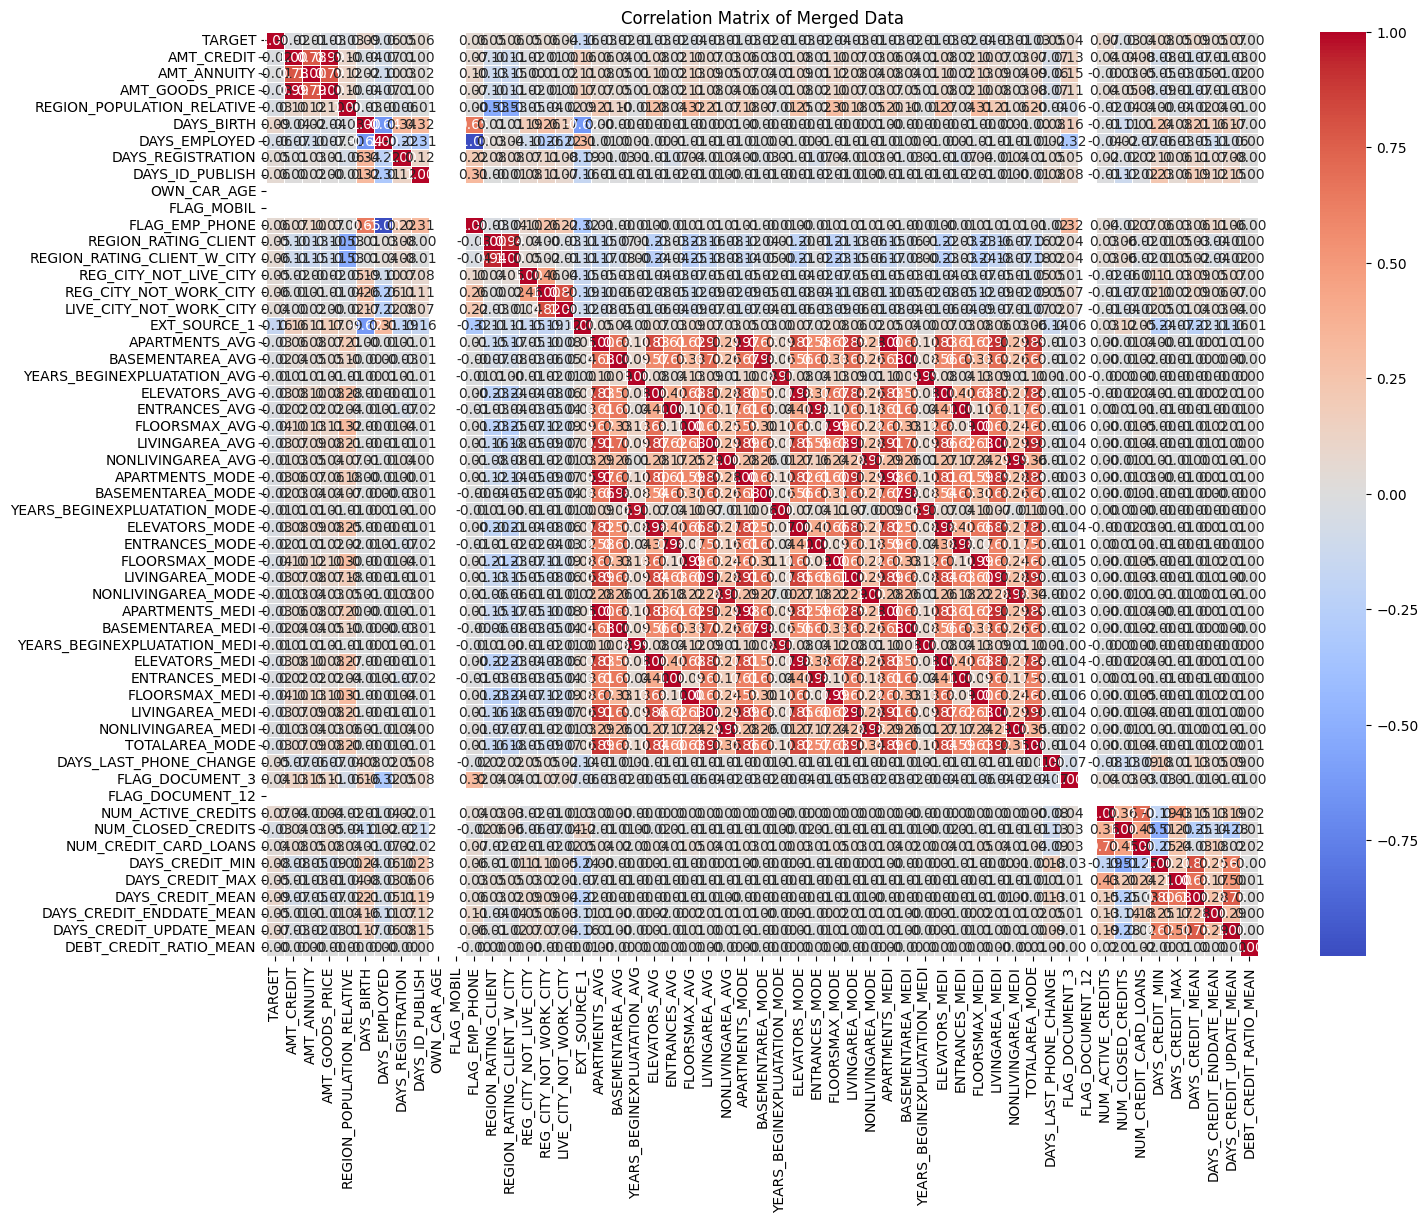

In [25]:
numeric_columns = merged_working.select_dtypes(include=['float64', 'int64']).columns

# Compute the correlation matrix for the numerical columns
correlation_matrix = merged_working[numeric_columns].corr()

# Plot the correlation matrix using a heatmap for better visualization
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Merged Data')
plt.show()

In [26]:
numeric_columns = merged_working.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = merged_working[numeric_columns].corr()

# Show the correlation matrix as text (full version)
print(correlation_matrix)

                                TARGET  AMT_CREDIT  AMT_ANNUITY  \
TARGET                        1.000000   -0.022311    -0.006535   
AMT_CREDIT                   -0.022311    1.000000     0.782018   
AMT_ANNUITY                  -0.006535    0.782018     1.000000   
AMT_GOODS_PRICE              -0.031770    0.986460     0.786280   
REGION_POPULATION_RELATIVE   -0.032879    0.099330     0.119643   
DAYS_BIRTH                    0.090986   -0.038855     0.019381   
DAYS_EMPLOYED                -0.055013   -0.070436    -0.103697   
DAYS_REGISTRATION             0.046502    0.006974     0.033743   
DAYS_ID_PUBLISH               0.058973    0.004542     0.022325   
OWN_CAR_AGE                        NaN         NaN          NaN   
FLAG_MOBIL                         NaN         NaN          NaN   
FLAG_EMP_PHONE                0.056051    0.069305     0.103069   
REGION_RATING_CLIENT          0.054222   -0.099181    -0.129014   
REGION_RATING_CLIENT_W_CITY   0.055807   -0.111207    -0.14577

In [27]:
threshold = 0.7
strong_correlations = correlation_matrix[(correlation_matrix >= threshold) | (correlation_matrix <= -threshold)]
# Display only non-null strong correlations (to focus on relevant pairs)
strong_correlations = strong_correlations.dropna(how='all', axis=0).dropna(how='all', axis=1)
print(strong_correlations)


                              TARGET  AMT_CREDIT  AMT_ANNUITY  \
TARGET                           1.0         NaN          NaN   
AMT_CREDIT                       NaN    1.000000     0.782018   
AMT_ANNUITY                      NaN    0.782018     1.000000   
AMT_GOODS_PRICE                  NaN    0.986460     0.786280   
REGION_POPULATION_RELATIVE       NaN         NaN          NaN   
DAYS_BIRTH                       NaN         NaN          NaN   
DAYS_EMPLOYED                    NaN         NaN          NaN   
DAYS_REGISTRATION                NaN         NaN          NaN   
DAYS_ID_PUBLISH                  NaN         NaN          NaN   
FLAG_EMP_PHONE                   NaN         NaN          NaN   
REGION_RATING_CLIENT             NaN         NaN          NaN   
REGION_RATING_CLIENT_W_CITY      NaN         NaN          NaN   
REG_CITY_NOT_LIVE_CITY           NaN         NaN          NaN   
REG_CITY_NOT_WORK_CITY           NaN         NaN          NaN   
LIVE_CITY_NOT_WORK_CITY  

In [28]:
# Create a new variable to capture the percentage of closed credits
merged_working['PCT_CLOSED_CREDITS'] = (merged_working['NUM_CLOSED_CREDITS'] / (merged_working['NUM_CLOSED_CREDITS'] + merged_working['NUM_ACTIVE_CREDITS']))

In [29]:
# Drop columns based on IV, correlation, missing values, and business logic
merged_working = merged_working.drop(columns=['FLAG_OWN_CAR', 'OWN_CAR_AGE', 'FLAG_DOCUMENT_12', 'FLAG_MOBIL', 'CODE_GENDER', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
                                              'YEARS_BEGINEXPLUATATION_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAREA_AVG',
                                              'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE','ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE',
                                              'LIVINGAREA_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'ELEVATORS_MEDI',
                                              'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'HOUSETYPE_MODE',
                                              'EMERGENCYSTATE_MODE', 'FLAG_DOCUMENT_3', 'LIVE_CITY_NOT_WORK_CITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
                                              'FLAG_EMP_PHONE', 'REGION_RATING_CLIENT_W_CITY', 'DAYS_CREDIT_MIN', 'DAYS_CREDIT_MAX', 'NUM_CLOSED_CREDITS', 'NUM_ACTIVE_CREDITS'
                                              ])

In [30]:
merged_working.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187261 entries, 0 to 202923
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   TARGET                      187261 non-null  int64  
 1   AMT_ANNUITY                 187252 non-null  float64
 2   NAME_INCOME_TYPE            187261 non-null  object 
 3   REGION_POPULATION_RELATIVE  187261 non-null  float64
 4   DAYS_BIRTH                  187261 non-null  int64  
 5   DAYS_EMPLOYED               187261 non-null  int64  
 6   DAYS_REGISTRATION           187261 non-null  float64
 7   DAYS_ID_PUBLISH             187261 non-null  int64  
 8   OCCUPATION_TYPE             120778 non-null  object 
 9   REGION_RATING_CLIENT        187261 non-null  int64  
 10  REG_CITY_NOT_LIVE_CITY      187261 non-null  int64  
 11  REG_CITY_NOT_WORK_CITY      187261 non-null  int64  
 12  ORGANIZATION_TYPE           187261 non-null  object 
 13  EXT_SOURCE_1       